In [1]:
#import all the libraries:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import csv
import re
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from scipy.sparse import hstack
import nltk
nltk.download('omw-1.4')
import matplotlib.pyplot as plt #import the plot
nltk.download('stopwords')
import matplotlib.pyplot as plt
#from wordcloud import WordCloud
import json
import numpy as np
from nltk import pos_tag, ngrams
#Balance the data:
from sklearn.utils import shuffle
import seaborn as sns
from collections import Counter

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Convert text content to a dictionary
# read in the text file using read_csv()
df = pd.read_csv('/kaggle/input/dataset-stances/stances.txt', delimiter='\t')
data = df.drop(df.columns[3:], axis=1)
# display the first few rows of the dataframe
print(data.head())

      topic                                               text  label
0  abortion  Need a ProLife R.E. Agent? - Support a ProLife...      1
1  abortion  Where is the childcare program @user which you...      1
2  abortion  I get several requests with petitions to save ...      1
3  abortion  we must always see others as Christ sees us,we...      1
4  abortion  PRAYERS FOR BABIES Urgent prayer one in Lexing...      1


In [3]:
target_counts = data['topic'].value_counts() #how many instances there are for each one of the events
print(target_counts)

hillary     984
feminist    949
abortion    933
atheism     733
climate     564
Name: topic, dtype: int64


In [4]:
label_counts = data['label'].value_counts() #how many instances there are for each one of the events
print(target_counts)

hillary     984
feminist    949
abortion    933
atheism     733
climate     564
Name: topic, dtype: int64


In [5]:
data.isna().sum() 

topic    0
text     0
label    0
dtype: int64

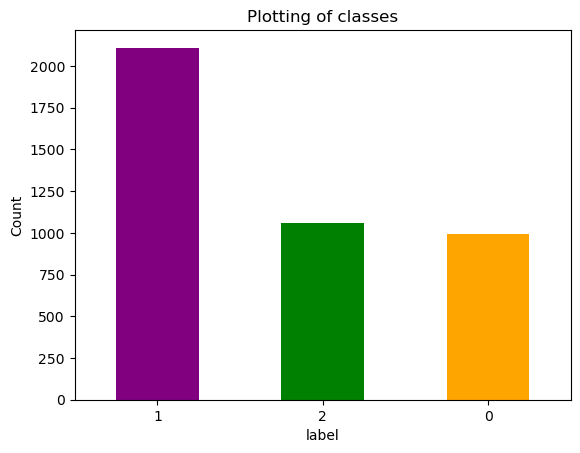

In [6]:
counts = data['label'].value_counts()
counts.plot(kind='bar', color=['purple', 'green','orange'])
plt.xlabel('label')
plt.ylabel('Count')
plt.title('Plotting of classes')
plt.xticks(rotation=0)
plt.show() #check the weight of each class

#### The data is imbalanced. To fix this, random instances of the majority class, 1, will be dropped.

In [7]:
# Shuffle the dataset to ensure randomness
dataf = shuffle(data, random_state=42)

# Count the number of samples in each class
class_counts = dataf['label'].value_counts()

# Undersample the "denial" class
desired_count = 1057
denial_count = class_counts[1]
undersampled_count = denial_count - desired_count

if undersampled_count > 0:
    dataf = dataf.drop(dataf[dataf['label'] == 1].sample(n=undersampled_count, random_state=42).index)

# Verify the class counts after undersampling
class_counts = dataf['label'].value_counts()
print(class_counts)

2    1057
1    1057
0     996
Name: label, dtype: int64


In [8]:
dataf = dataf.reset_index(drop=True)

In [9]:
# Verify the class counts after undersampling
class_counts = dataf['label'].value_counts()
print(class_counts)

2    1057
1    1057
0     996
Name: label, dtype: int64


## Tokenizer

In [10]:
#Import Tweet Tokenizer:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()

In [11]:
#Get the tweets text and check how they look like:
tweets =[]
words_list =[]
for tweet in dataf["text"]:
    tweet = tweet.lower()
    tweets.append(tweet)

print(tweets[1])

rt @user hillary for the win #semst, 


# Preprocessing

## Abreviations

In [12]:
!pip install pysbd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 3.4 MB/s eta 0:00:00


In [13]:
import pysbd
import re

# Define a dictionary of common abbreviations and their expanded forms
abbreviations = {
"afaik": "as far as i know",
"ama": "ask me anything",
"amp" : "and",
"asl": "age/sex/location",
"b4": "before",
"bae": "before anyone else",
"b/c": "because",
"bc": "because",
"bff": "best friends forever",
"brb": "be right back",
"btaim": "be that as it may",
"bts": "behind the scenes",
"btw": "by the way",
"bs": "bullshit",
"dae": "does anyone know?",
"dftba": "don’t forget to be awesome",
"dyk": "did you know",
"cause": "because",
"cuz": "because",
"eli5": "explain like i’m 5 (years old)",
"effing": "fucking",
"f2f": "face to face",
"fbf": "flashback friday",
"ffs": "for f***’s sake",
"fml": "f*** my life",
"fomo": "fear of missing out",
"ftfy": "fixed that for you",
"ftw": "for the win",
"futab": "feet up, take a break",
"fwiw": "for what it’s worth",
"fyi": "for your information",
    "gg": "good game",
"gr8": "great",
"gtg": "got to go",
"gtr": "got to run",
"h/t": "hat tip",
"hbd": "happy birthday",
"hth": "here to help / happy to help",
"hmb": "hit me back",
"hmu": "hit me up",
"ianad": "i am not a doctor",
"ianal": "i am not a lawyer",
"icymi": "in case you missed it",
"idc": "i don’t care",
"idk": "i don’t know",
"ikr": "i know, right?",
"ily": "i love you",
"imho": "in my humble opinion",
"imo": "in my opinion",
"irl": "in real life",
"iso": "in search of",
"jk": "just kidding",
"jtm": "just the messenger",
"l8": "late",
"lmao": "laughing my a** off",
"lmk": "let me know",
"lol": "laughing out loud",
"mtfbwy": "may the force be with you",
"myob": "mind your own business",
"myfb" : "mind your fucking business",
"nbd": "no big deal",
"nm": "not much",
"nsfw": "not safe for work",
"nvm": "nevermind",
"nyt": "name your trade",
"obv": "obviously",
"oh": "overheard",
"omg": "oh my god",
"omw": "on my way",
"orly": "oh really?",
"ofc": "of course",
"pls": "please",
"plz" : "please",
"pic" : "picture",
"pics" : "pictures",
"ppl": "people",
"potd": "photo of the day",
"psa": "public service announcement",
"qotd": "quote of the day",
"perf": "perfect",
"perv": "pervert",
"rn": "right now",
"rofl": "rolling on the floor laughing",
"srsly": "seriously",
"np": "no problem",
"nr": "no reply",
"tht" : "that",
"nra":"national rifle association",
"lmao" : "laughing my ass off",
"asap" : "as soon as possible",
"atm" : "at the moment",
"mins" : "minutes",
"probs": "probably",
"luv" : 'love'
}
# Define a function to replace abbreviations with their expanded forms
def replace_abbreviations(text):
    # Initialize the sentence boundary detector
    segmenter = pysbd.Segmenter(language="en", clean=False)

    # Split the text into sentences
    sentences = segmenter.segment(text)

    # Loop over the sentences
    for i, sentence in enumerate(sentences):
        # Loop over the abbreviations
        for abbreviation, expansion in abbreviations.items():
            # Replace the abbreviation with the expansion
            sentence = re.sub(r"\b" + abbreviation + r"\b", expansion, sentence)

        # Update the sentence in the list of sentences
        sentences[i] = sentence

    # Join the sentences back into a single string
    normalized_text = " ".join(sentences)

    return normalized_text


normalized_tweets = [replace_abbreviations(tweet) for tweet in tweets]

In [14]:
normalized_tweets[2] #test example

'i #denounceharper for refusing to include family planning in foreign aid even though spending $1 could save $6 #wheresthefp #semst, '

## Mispellings

In [15]:
from textblob import TextBlob 

def correct_spelling(text_list):
    corrected_list = []
    for text in text_list:
        corrected_text = []
        for word in text.split():
            corrected_word = str(TextBlob(word).correct())
            corrected_text.append(corrected_word)
        corrected_list.append(" ".join(corrected_text))
    return corrected_list

In [16]:
corrected_list = correct_spelling(normalized_tweets)
#print(corrected_list)

In [17]:
dataf['corrected_tweets'] = corrected_list #list of tweets that don't have misspellings and abbreviations.

In [18]:
#Get the tweets text and check how they look like:
corrected_list =[]
words_list =[]
for tweet in dataf["corrected_tweets"]:
    tweet = tweet.lower() #lower case the characters 
    corrected_list.append(tweet)

print(corrected_list[1])

it @user axillary for the win #set,


## Stop-words Removal

#### Step for the extraction of the more pragmatic features.

In [19]:
# Manually select the stopwords that are nedeed:
stopwords = nltk.corpus.stopwords.words('english')
print(stopwords)
exclude_words = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself','they', 'them', 'their', 'theirs', 'themselves', 'no', 'not', "don't",'should', "should've", "against", 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

new_stopwords = [word for word in stopwords if word not in exclude_words]
print(new_stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

## Extract URLS 

#### The more pragmatic features text keep hashtags,mentions and punctuation but not certain stopwords. The syntactic text doesn't keep the hashtags and mentions but keeps the stopwords and punctuation.

In [20]:
def preprocess_tweets(tweet_list):
    tweets_preprocess = []
    for tweet in tweet_list: 
        # Remove URLs
        tweet = re.sub(r'http\S+', '', tweet)
        # Remove special characters except for apostrophes and punctuation:
        tweet = re.sub(r'[^\w\s\'\.\,\!\?\""]', '', tweet)
        tweets_preprocess.append(tweet)

    return tweets_preprocess
processed_tweets_syn = preprocess_tweets(corrected_list)
print(processed_tweets_syn[1])

it user axillary for the win set,


In [21]:
def preprocess_tweets(tweet_list):
    tweets_preprocess = []
    for tweet in tweet_list: 
        # Remove URLs
        tweet = re.sub(r'http\S+', '', tweet)
        # Remove special characters except for apostrophes, punctuation, mentions and hashtags:
        tweet = re.sub(r'[^\w\s\#\@\'\""\.\,\!\?]', '', tweet)
        tweets_preprocess.append(tweet)

    return tweets_preprocess
processed_tweets_prag = preprocess_tweets(corrected_list)
print(processed_tweets_prag[1])

it @user axillary for the win #set,


### More Pragmatic preprocessing

In [22]:
prag_tweets = []
for tweet in processed_tweets_prag:
    # convert tweet to lowercase and split into words
    tweet_words = tweet.lower().split()
    # remove stopwords from tweet and join back into string
    tweet_proc = ' '.join([word for word in tweet_words if word not in new_stopwords])
    prag_tweets.append(tweet_proc)
dataf['prag_text'] = prag_tweets

### More Syntactic preprocessing

In [23]:
syn_tweets = []
for tweet in processed_tweets_syn:
    # convert tweet to lowercase and split into words
    tweet_words = tweet.lower().split()
    tweet_proc = ' '.join (tweet_words)
    syn_tweets.append(tweet_proc)
dataf['syn_text'] = syn_tweets

# Features

## N-grams

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF
import numpy as np
import pandas as pd


# Create the CountVectorizer object for n-grams
vectorizer = CountVectorizer(ngram_range=(2, 2))

# Fit the vectorizer on the semantic text for n-grams
X_bow_ngrams = vectorizer.fit_transform(dataf['prag_text'])

# Get the feature names (bigram names)
feature_names = vectorizer.get_feature_names_out()

# Apply dimensionality reduction to the original n-grams using NMF
nmf_ngrams = NMF(n_components=60)  # Reduce to 60 dimensions
X_reduced_ngrams = nmf_ngrams.fit_transform(X_bow_ngrams)

# Create a new DataFrame with the reduced n-grams representation
bow_df_ngrams = pd.DataFrame(X_reduced_ngrams)

# Rename the columns with actual bigram names
bow_df_ngrams.columns = feature_names[:60]

# Concatenate all the components into a single array
all_components = np.concatenate(nmf_ngrams.components_)

# Reshape the array to match the number of features
all_components_reshaped = all_components.reshape(len(nmf_ngrams.components_), -1)

# Compute the sum of values for each bigram across all the components
bigram_sums = np.sum(all_components_reshaped, axis=0)

# Get the indices of the top 60 bigrams with the highest sums
top_indices = np.argsort(bigram_sums)[::-1][:60]

# Get the corresponding top 60 bigrams
top_bigrams = [feature_names[i] for i in top_indices]

# Create a new DataFrame to store the top 60 bigrams and counts
dataf_bigrams = pd.DataFrame(columns= ["Sentence"] + top_bigrams)

# Iterate over each sentence in the original DataFrame
for idx, sentence in enumerate(dataf['prag_text']):
    sentence_counts = [sentence]
    
    # Count the occurrences of each top bigram in the sentence
    for bigram in top_bigrams:
        count = sentence.count(bigram)
        sentence_counts.append(count)
    
    # Append the sentence counts as a new row in the DataFrame
    dataf_bigrams.loc[idx] = sentence_counts
    
dataf_bigrams = dataf_bigrams.drop('Sentence', axis=1)
# Print the DataFrame with the top 60 bigrams and their counts

print(dataf_bigrams)

      user user  don want  you don  you know  gamergate set  you want  \
0             0         0        0         0              0         0   
1             0         0        0         0              0         0   
2             0         0        0         0              0         0   
3             0         0        0         0              0         0   
4             0         0        0         0              0         0   
...         ...       ...      ...       ...            ...       ...   
3105          0         0        0         0              0         0   
3106          0         0        0         0              0         0   
3107          0         0        0         0              0         0   
3108          0         0        0         0              0         0   
3109          0         0        0         0              0         0   

      know what  you can  what best  they re  ...  right now  need feminist  \
0             0        0          0        0

In [26]:
dataf = pd.concat([dataf, dataf_bigrams], axis=1) #the n-grams aren't exactly the same ones every time the code runs. Later on, the dataset used to train the models will be the one used on the thesis.

In [27]:
columns_to_keep = ['topic', 'text', 'label', 'corrected_tweets', 'prag_text', 'syn_text'] ###use this in case there are features that you dont want
dataf = dataf[columns_to_keep] 

## Pragmatic features

In [28]:
!pip install twython

### Sentiment Analysis

In [29]:
# Get the sentiment feature with VADER:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# initialize VADER
sia = SentimentIntensityAnalyzer()

# create a list to store the sentiment scores
sentiment_scores = []

# loop through each preprocessed tweet and get the sentiment score using VADER
for tweet in prag_tweets:
    sentiment_scores.append(sia.polarity_scores(tweet))

# create a list to store the sentiment labels
sentiment_labels = []

# loop through each sentiment score and assign a label based on the compound score
for score in sentiment_scores:
    if score['compound'] >= 0.05:
        sentiment_labels.append(2) #Positive 
    elif score['compound'] <= -0.05:
        sentiment_labels.append(1) #Negative
    else:
        sentiment_labels.append(0) #Neutral

# add the sentiment labels as a new column to the dataframe
dataf['sentiment'] = sentiment_labels

### Emotion Detection

In [30]:
# Define the path to the folder containing the EmoLex files
path = "/kaggle/input/emotions-lexicon/OneFilePerEmotion/"

# Define a list of the EmoLex filenames and their corresponding emotions
emolex_files = [('anger-NRC-Emotion-Lexicon.txt', 'anger'), ('anticipation-NRC-Emotion-Lexicon.txt', 'anticipation'), ('disgust-NRC-Emotion-Lexicon.txt', 'disgust'),('fear-NRC-Emotion-Lexicon.txt', 'fear'), ('joy-NRC-Emotion-Lexicon.txt', 'joy'), ('sadness-NRC-Emotion-Lexicon.txt', 'sadness'), ('surprise-NRC-Emotion-Lexicon.txt', 'surprise'), ('trust-NRC-Emotion-Lexicon.txt', 'trust')]

# Create an empty data frame to store the combined data
emolex_data = pd.DataFrame(columns=['word', 'emotion', 'file'])

# Load and process each EmoLex file
for file, emotion in emolex_files:
    # Load the file into a data frame
    df = pd.read_csv(path + file, sep='\t', header=None, names=['word', 'emotion'])
    
    # Add a new column to store the emotion type for each word
    df['file'] = emotion
    
    # Append the data to the combined data frame
    emolex_data = emolex_data.append(df, ignore_index=True)
    
# filter the dataframe to remove rows with value equal to 0
emolex_df = emolex_data[emolex_data['emotion'] != 0]

# Define the mapping between emotion names and values
emotion_map = {'anger': 1, 'anticipation': 2, 'disgust': 3, 'fear': 4, 'joy': 5, 'sadness': 6, 'surprise': 7, 'trust': 8}

# Add a new column "emotion_value" based on the mapping
emolex_df['emotion_value'] = emolex_df['file'].apply(lambda x: emotion_map.get(x, 0))

def extract_emotions(sentences):
    emotions = []
    for sentence in sentences:
        sentence_emotions = []
        words = tokenizer.tokenize(sentence)
        for word in words:
            matches = emolex_df[emolex_df['word'] == word]
            if len(matches) > 0:
                for emotion in matches['emotion_value']:
                    if emotion not in sentence_emotions:
                        sentence_emotions.append(emotion)
        emotions.append(sentence_emotions)
    return emotions

sentences = prag_tweets
emotions = extract_emotions(sentences)
dataf['emotions'] = emotions

emotions = [1, 2, 3, 4, 5, 6, 7, 8]

# Iterate through each emotion and add a column to the DataFrame
for emotion in emotions:
    dataf[emotion] = 0  # Initialize the column with zeros

# Iterate through each row in the DataFrame
for idx, row in dataf.iterrows():
    sentence = row['prag_text']
    sentence_emotions = extract_emotions([sentence])[0]
    emotion_counts = Counter(sentence_emotions)
    
    # Update the corresponding emotion columns with the frequency counts
    for emotion, count in emotion_counts.items():
        dataf.at[idx, emotion] = count

/tmp/ipykernel_20/3785098317.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  emolex_data = emolex_data.append(df, ignore_index=True)
/tmp/ipykernel_20/3785098317.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  emolex_data = emolex_data.append(df, ignore_index=True)
/tmp/ipykernel_20/3785098317.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  emolex_data = emolex_data.append(df, ignore_index=True)
/tmp/ipykernel_20/3785098317.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  emolex_data = emolex_data.append(df, ignore_index=True)
/tmp/ipykernel_20/3785098317.py:19: FutureWarning: The frame.append method is deprecated and

### Positive and Negative words

In [31]:
!pip install afinn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for afinn: filename=afinn-0.1-py3-none-any.whl size=53447 sha256=8d57a8da00f61b9232a4eddfaf0a9bf9e6f5428fbce608756c25fca13765fade
  Stored in directory: /root/.cache/pip/wheels/b0/05/90/43f79196199a138fb486902fceca30a2d1b5228e6d2db8eb90
Successfully built afinn


In [32]:
import afinn

In [33]:
from afinn import Afinn
# Instantiate the Afinn object
afinn = Afinn()


# Function to calculate count of positive and negative words for each sentence
def calculate_positive_negative_word_counts(dataf):
    positive_word_counts = []
    negative_word_counts = []

    for text in dataf['prag_text']:
        # Tokenize the text into words
        words = tokenizer.tokenize(text)

        # Initialize count variables
        positive_count = 0
        negative_count = 0

        # Calculate count of positive and negative words
        for word in words:
            score = afinn.score(word)
            if score > 0:
                positive_count += 1
            elif score < 0:
                negative_count += 1

        positive_word_counts.append(positive_count)
        negative_word_counts.append(negative_count)

    dataf['positive_word_count'] = positive_word_counts
    dataf['negative_word_count'] = negative_word_counts

calculate_positive_negative_word_counts(dataf)

In [34]:
def calculate_positive_negative_word_ratio(dataf):
    positive_word_ratios = []
    negative_word_ratios = []

    for text in dataf['prag_text']:
        # Tokenize the text into words
        words = tokenizer.tokenize(text)

        # Initialize count variables
        positive_count = 0
        negative_count = 0

        # Calculate count of positive and negative words
        for word in words:
            score = afinn.score(word)
            if score > 0:
                positive_count += 1
            elif score < 0:
                negative_count += 1

        total_count = positive_count + negative_count

        # Calculate ratios
        positive_ratio = positive_count / total_count if total_count > 0 else 0
        negative_ratio = negative_count / total_count if total_count > 0 else 0

        positive_word_ratios.append(positive_ratio)
        negative_word_ratios.append(negative_ratio)

    dataf['positive_word_ratio'] = positive_word_ratios
    dataf['negative_word_ratio'] = negative_word_ratios

calculate_positive_negative_word_ratio(dataf)

## Structural Features

### Sentence Length

In [35]:
# Function to calculate sentence length
def calculate_sentence_length(sentence):
    words = tokenizer.tokenize(sentence)
    sentence_length = len(words)
    return sentence_length
dataf['sentence_length'] = dataf['syn_text'].apply(calculate_sentence_length)

### Discourse Connectives

In [36]:
def count_discourse_connectives(dataframe):
    discourse_connectives = ['after', 'also', 'although', 'as', 'as a result', 'as if', 'as long as', 'as soon as', 'because', 'before', 'but', 'by contrast', 'even if', 'even though', 'finally', 'for example', 'for instance', 'however', 'if', 'in addition', 'indeed', 'in fact', 'instead', 'in turn', 'in turn', 'later', 'meanwhile', 'moreover', 'nevertheless', 'nonetheless', 'now that', 'once', 'once', 'on the other hand', 'otherwise', 'previously', 'separately', 'since', 'so that', 'still', 'then', 'therefore', 'though', 'thus', 'unless', 'until', 'when', 'while', 'yet']
    combined_count = []
    for sentence in dataframe['syn_text']:
        counts = {disc_con_word: 0 for disc_con_word in discourse_connectives}
        # Count discourse connectives in the sentence
        for disc_con_word in discourse_connectives:
            counts[disc_con_word] = sentence.split().count(disc_con_word)
        # Calculate the combined frequency of pronouns
        combined_freq = sum(counts.values())
        combined_count.append(combined_freq)

    # Create a new DataFrame with the combined pronoun counts
    combined_df = pd.DataFrame({'discourse_connectives_count': combined_count})

    # Concatenate the new DataFrame with the original DataFrame
    new_dataframe = pd.concat([dataframe, combined_df], axis=1)

    return new_dataframe

dataf = count_discourse_connectives(dataf)

In [37]:
dataf['discourse_connectives_ratio'] = dataf['discourse_connectives_count'] / dataf['sentence_length']

### Punctuation

In [38]:
import string

def calculate_punctuation_ratio(text):
    # Remove leading and trailing whitespace from the text
    text = text.strip()
    
    # Calculate the total number of punctuation marks in the text
    total_punctuation = sum(text.count(p) for p in string.punctuation)
    
    # Split the text into sentences
    sentences = text.split('.')
    
    # Calculate the number of sentences
    num_sentences = len(sentences)
    
    # Calculate the ratio of punctuation per sentence
    if num_sentences > 0:
        ratio = total_punctuation / num_sentences
    else:
        ratio = 0.0
    
    return ratio

dataf['punctuation_ratio'] = dataf['syn_text'].apply(calculate_punctuation_ratio)

### Repeated Punctuation

In [39]:
def calculate_repeated_punctuation_ratio(sentence):
    # Define the punctuation symbols of interest
    punctuation_symbols = set(string.punctuation)

    # Remove spaces to avoid counting repeated spaces as punctuation
    sentence = sentence.replace(" ", "")

    # Count the total number of punctuation symbols
    total_punctuation_count = sum(char in punctuation_symbols for char in sentence)

    # Count the number of punctuation symbols that occur more than once
    repeated_punctuation_count = 0
    char_count = {}
    for char in sentence:
        if char in punctuation_symbols:
            char_count[char] = char_count.get(char, 0) + 1
            if char_count[char] > 1:
                repeated_punctuation_count += 1

    # Calculate the ratio of repeated punctuation
    if total_punctuation_count > 0:
        repeated_punctuation_ratio = repeated_punctuation_count / total_punctuation_count
    else:
        repeated_punctuation_ratio = 0

    return repeated_punctuation_ratio


# Add a new column to store the repeated punctuation ratio
dataf['repeated_punctuation_ratio'] = dataf['syn_text'].apply(calculate_repeated_punctuation_ratio)

# Print the DataFrame with the repeated punctuation ratio
dataf.head()

,topic,text,label,corrected_tweets,prag_text,syn_text,sentiment,emotions,1,2,...,8,positive_word_count,negative_word_count,positive_word_ratio,negative_word_ratio,sentence_length,discourse_connectives_count,discourse_connectives_ratio,punctuation_ratio,repeated_punctuation_ratio
0,feminist,"Because women are seen as ""soft,"" ""weak,"" and ...",2,"because women are seen as ""soft,"" ""weak,"" and ...","women seen ""soft,"" ""weak,"" ""emotional"" eyes ma...","because women are seen as ""soft,"" ""weak,"" and ...",0,[],0,0,...,0,0,1,0.0,1.0,25,2,0.080000,9.0,0.777778
1,hillary,"RT @user Hillary for the win #SemST,",2,"it @user axillary for the win #set,","@user axillary win #set,","it user axillary for the win set,",2,[],0,0,...,0,1,0,1.0,0.0,8,0,0.000000,1.0,0.000000
2,abortion,I #DenounceHarper for refusing to include fami...,2,i #denounceharper for refusing to include fami...,i #denounceharper refusing include family plan...,i denounceharper for refusing to include famil...,2,"[2, 8, 5]",0,1,...,1,1,1,0.5,0.5,21,1,0.047619,1.0,0.000000
3,abortion,If it's getting old maybe you should stop call...,2,if it's getting old maybe you should stop call...,getting old maybe you should stop calling embr...,if it's getting old maybe you should stop call...,1,[],0,0,...,0,0,1,0.0,1.0,15,1,0.066667,1.5,0.000000
4,feminist,"Well maybe if more men learned to take ""no"" as...",2,"well maybe if more men learned to take ""no"" as...","well maybe men learned take ""no"" answer, women...","well maybe if more men learned to take ""no"" as...",2,[],0,0,...,0,0,1,0.0,1.0,26,3,0.115385,5.0,0.400000


### Hashtags

In [40]:
# Function to count hashtags in a text
def count_hashtags(text):
    hashtags = re.findall(r'#\w+', text)  # Find all hashtags using regex
    return len(hashtags)  # Return the count of hashtags

dataf['hashtag_count'] = dataf['text'].apply(count_hashtags)

In [41]:
dataf['hashtag_ratio'] = dataf['hashtag_count'] / dataf['sentence_length']

### Mention

In [42]:
def count_mentions(text):
    mentions = re.findall(r'@\w+', text)  # Find all mentions using regex
    return len(mentions)

dataf['mention_count'] = dataf['text'].apply(count_mentions)

In [43]:
dataf['mention_ratio'] = dataf['mention_count'] / dataf['sentence_length']

### Capital Characters

In [44]:
def calculate_counts_capital_characters(text):
    return sum(1 for c in text if c.isupper())

dataf['capital_counts'] = dataf['text'].apply(calculate_counts_capital_characters)

In [45]:
dataf['capital_ratios'] = dataf['capital_counts'] / dataf['sentence_length']

## Syntactic Features

### POS tags

In [46]:
from collections import defaultdict

#Tokenize the text for the models:
tokens_pos = [tokenizer.tokenize(text) for text in syn_tweets]

# Define the groups of POS tags
noun_tags = ['NN', 'NNS', 'NNP', 'NNPS']
pronoun_tags = ['PRP', 'PRP$', 'WP', 'WP$']
verb_tags = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
adjective_tags = ['JJ', 'JJR', 'JJS']
adverb_tags = ['RB', 'RBR', 'RBS', 'WRB']
determiner_tags = ['DT', 'PDT', 'WDT']
preposition_conjunction_tags = ['IN', 'CC', 'TO']
other_tags = ['EX', 'FW', 'LS', 'MD', 'POS', 'RP', 'SYM', 'UH'] 

# Combine all groups of tags into a single list
pos_tags = noun_tags + pronoun_tags + verb_tags + adjective_tags + adverb_tags + determiner_tags + preposition_conjunction_tags + other_tags

tag_counts = []

for tokens in tokens_pos:
    pos = nltk.pos_tag(tokens)
    counts = defaultdict(int)  # Using defaultdict to handle missing tags
    for _, tag in pos:
        if tag in pos_tags:
            if tag in noun_tags:
                counts['Noun'] += 1
            elif tag in pronoun_tags:
                counts['Pronoun'] += 1
            elif tag in verb_tags:
                counts['Verb'] += 1
            elif tag in adjective_tags:
                counts['Adjective'] += 1
            elif tag in adverb_tags:
                counts['Adverb'] += 1
            elif tag in determiner_tags:
                counts['Determiner'] += 1
            elif tag in preposition_conjunction_tags:
                counts['Preposition/Conjunction'] += 1
            else:
                counts['Other'] += 1
    tag_counts.append(counts)

dfpos = pd.DataFrame(tag_counts)
dfpos.fillna(0, inplace=True)
dfpos.head()
dataf = dataf.join(dfpos)

### POS bigrams

In [47]:
def generate_pos_bigrams(text_list):
    pos_bigrams_list = []
    for text in text_list:
        words = tokenizer.tokenize(text)
        pos_tags = pos_tag(words)
        pos_tags_only = [tag for _, tag in pos_tags]
        pos_bigrams = ngrams(pos_tags_only, 2)
        pos_bigrams_list.append(list(pos_bigrams))
    return pos_bigrams_list

pos_bigrams = generate_pos_bigrams(syn_tweets)
dataf['pos_bigrams'] = pos_bigrams

In [48]:
# Flatten the lists in the 'pos_bigrams' column and convert inner lists to tuples
flat_pos_bigrams = [tuple(item) for sublist in dataf['pos_bigrams'] for item in sublist]

# Count the occurrences of each POS bigram
pos_bigram_counts = Counter(flat_pos_bigrams)

# Print the top 60 most common POS bigrams
#for pos_bigram, count in pos_bigram_counts.most_common(60):
    #print(f"POS bigram: {pos_bigram}, Count: {count}")

In [49]:
dataf = dataf.drop('pos_bigrams', axis=1)

In [50]:
pos_2grams = [('NN_NN'), ('JJ_NN'), ('DT_NN'), ('NN_IN'), ('IN_NN'), ('IN_DT'), ('TO_VB'), ('NN_VBZ'), ('DT_JJ'), ('JJ_NNS'), ('NNS_VBP'), ('PRP_VBP'), ('RB_JJ'), ('IN_JJ'), ('PRP$_NN'), ('NN_RB'), ('NNS_IN'), ('MD_VB'), ('NN_NNS'), ('IN_PRP'), ('NN_CC'), ('JJ_JJ'), ('NN_VBP'), ('VB_DT'), ('NN_JJ'), ('VB_NN'), ('CD_NN'), ('NN_PRP'), ('NN_VBD'), ('RB_VB'), ('NN_TO'), ('RB_RB'), ('NNS_VBD'), ('IN_PRP$'), ('IN_NNS'), ('VBZ_DT'), ('DT_NNS'), ('JJ_IN'), ('VBP_JJ'), ('VB_IN'), ('RB_IN'), ('VBP_NN'), ('PRP_VBZ'), ('VB_JJ'), ('NN_MD'), ('NN_DT'), ('VBP_DT'), ('VBN_IN'), ('NN_VBN'), ('VBZ_JJ'), ('VB_PRP'), ('NN_VBG'), ('VBG_NN'), ('VBZ_RB'), ('CC_NN'), ('IN_VBG'), ('VBP_IN'), ('NN_CD'), ('NNS_RB'), ('VBP_RB')]

pos2_counts = []

for text in syn_tweets:
    counts = {}
    words = tokenizer.tokenize(text)
    pos_tags = pos_tag(words)
    for i in range(len(pos_tags)-1):
        pos2 = pos_tags[i][1] + '_' + pos_tags[i+1][1]
        if pos2 in pos_2grams:
            counts[pos2] = counts.get(pos2, 0) + 1
    pos2_counts.append(counts)

df_pos2 = pd.DataFrame(pos2_counts)
df_pos2.fillna(0, inplace=True)
dataf = dataf.join(df_pos2)

### Dependency Parsing

In [51]:
import spacy

nlp = spacy.load("en_core_web_sm")

dependencies = ['ROOT', 'acl', 'acomp', 'advcl', 'advmod', 'agent', 'amod', 'appos', 'attr', 'aux', 'auxpass', 'case', 'cc', 'ccomp', 'compound', 'conj', 'csubj', 'csubjpass', 'dative', 'dep', 'det', 'dobj', 'expl', 'intj', 'mark', 'meta', 'neg', 'nmod', 'npadvmod', 'nsubj', 'nsubjpass', 'nummod', 'oprd', 'parataxis', 'pcomp', 'pobj', 'poss', 'preconj', 'predet', 'prep', 'prt', 'punct', 'quantmod', 'relcl', 'xcomp']

dep_counts = []

for text in syn_tweets:
    doc = nlp(text)
    counts = {}
    for dep in doc:
        if dep.dep_ in dependencies:
            counts[dep.dep_] = counts.get(dep.dep_, 0) + 1
    dep_counts.append(counts)

df_dep = pd.DataFrame(dep_counts)
df_dep.fillna(0, inplace=True)
dataf = dataf.join(df_dep)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

### Dependencies Bigrams

In [52]:
def extract_dependency_bigrams(sentences):
    dependency_bigrams = []
    for sentence in sentences:
        doc = nlp(sentence)
        sentence_dependency_bigrams = []
        previous_token = None
        for token in doc:
            if previous_token is not None:
                sentence_dependency_bigrams.append((previous_token.dep_, token.dep_))
            previous_token = token
        dependency_bigrams.append(sentence_dependency_bigrams)
    return dependency_bigrams
dependencies_bigrams = extract_dependency_bigrams(syn_tweets)
dataf['dependencies_bigrams'] = dependencies_bigrams

In [53]:
import itertools

# Get the most common dependency bigrams
def get_most_common_dependencies_bi(dataf):
    dependencies = ['_'.join(dep) for dep_list in dataf['dependencies_bigrams'] for dep in dep_list]
    return Counter(dependencies).most_common(60)

deps_bi = get_most_common_dependencies_bi(dataf)

#print("Most common dependency bigrams:", deps_bi)

In [54]:
target_bigrams = [('ROOT', 'punct'), ('nsubj', 'ROOT'), ('pobj', 'punct'), ('prep', 'pobj'), ('compound', 'compound'), ('punct', 'ROOT'), ('nsubj', 'aux'), ('dobj', 'punct'), ('prep', 'det'), ('punct', 'nsubj'), ('dobj', 'prep'), ('punct', 'compound'), ('compound', 'ROOT'), ('nsubj', 'ccomp'), ('det', 'amod'), ('compound', 'nsubj'), ('ROOT', 'det'), ('compound', 'pobj'), ('pobj', 'prep'), ('det', 'pobj'), ('ROOT', 'prep'), ('aux', 'xcomp'), ('det', 'dobj'), ('aux', 'neg'), ('ROOT', 'dobj'), ('compound', 'dobj'), ('amod', 'pobj'), ('cc', 'conj'), ('mark', 'nsubj'), ('aux', 'ROOT'), ('amod', 'dobj'), ('amod', 'compound'), ('punct', 'punct'), ('nsubj', 'advcl'), ('det', 'nsubj'), ('attr', 'punct'), ('amod', 'nsubj'), ('advmod', 'ROOT'), ('prep', 'compound'), ('ROOT', 'nsubj'), ('ROOT', 'advmod'), ('prep', 'poss'), ('det', 'compound'), ('advmod', 'punct'), ('nsubj', 'relcl'), ('advmod', 'nsubj'), ('punct', 'amod'), ('conj', 'punct'), ('neg', 'ROOT'), ('punct', 'advmod'), ('prep', 'amod'), ('nsubj', 'advmod'), ('det', 'attr'), ('acomp', 'punct'), ('advmod', 'advmod'), ('ROOT', 'acomp'), ('ccomp', 'punct'), ('ROOT', 'aux'), ('amod', 'ROOT'), ('nsubj', 'prep')]

# Create an empty DataFrame to store the presence of target bigrams
presence_dataf = pd.DataFrame()

# Iterate over each target bigram
for i, bigram in enumerate(target_bigrams):
    presence = []

    # Iterate over each row and check if the target bigram is present
    for row in dataf['dependencies_bigrams']:
        found = False
        for dep_bigram_list in row:
            if dep_bigram_list == list(bigram):
                found = True
                break
        if found:
            presence.append(1)
        else:
            presence.append(0)

    # Store the presence list in the DataFrame as a new column with the bigram words as column name
    column_name = '_'.join(bigram)
    presence_dataf[column_name] = presence
    
dataf = pd.concat([dataf, presence_dataf], axis=1)

### Complement Clauses

In [55]:
def extract_complement_clauses(texts):
    complement_clauses = []
    for text in texts:
        doc = nlp(text)
        for token in doc:
            if token.dep_ in ["ccomp", "xcomp"] and token.head.pos_ in ["VERB", "ADJ", "NOUN"]:
                complement_clauses.append(" ".join([t.text for t in token.subtree]))
    return complement_clauses

In [56]:
import spacy

nlp = spacy.load("en_core_web_sm")

In [57]:
sentence = ['I dont know why is did that']
print(extract_complement_clauses(sentence))

['why is did that']


In [58]:
def count_complement_clauses(texts):
    complement_clauses = extract_complement_clauses(texts)
    counts = []
    for text in texts:
        doc = nlp(text)
        sentence_count = 0
        for token in doc:
            if token.dep_ in ["ccomp", "xcomp"] and token.head.pos_ in ["VERB", "ADJ", "NOUN"]:
                sentence_count += complement_clauses.count(" ".join([t.text for t in token.subtree]))
        counts.append(sentence_count)
    return counts

In [59]:
counts = count_complement_clauses(syn_tweets)
dataf['complement_clause_count'] = counts

In [60]:
dataf['complement_clause_ratio'] = dataf['complement_clause_count']/dataf['sentence_length']

### Adverbial Clauses

In [61]:
def extract_adverbial_clauses(text):
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text)
    adverbial_clauses = []
    
    for sentence in doc.sents:
        for token in sentence:
            if token.dep_ == "advcl":
                clause = ' '.join([t.text for t in token.subtree])
                adverbial_clauses.append(clause)
    
    return adverbial_clauses

In [62]:
def count_adverbial_clauses(dataset):
    adverbial_clause_counts = []
    
    for text in dataset:
        nlp = spacy.load("en_core_web_sm")
        doc = nlp(text)
        sentence_count = 0
        for token in doc:
            if token.dep_ == "advcl":
                sentence_count += 1
        adverbial_clause_counts.append(sentence_count)
    
    return adverbial_clause_counts

dataf['count_adv_clause'] = count_adverbial_clauses(dataf['syn_text'])

In [63]:
dataf['ratio_adv_clause'] = dataf['count_adv_clause']/dataf['sentence_length']

## Lexical Features

### Stance Adverbs

In [64]:
def count_stance_adverbs(dataframe):
    stance_adverbs = adverbials = [
    'honestly', 'truthfully', 'truly', 'truthfulness', 'mildly', 'frankly',
    'honestly','literally',
    'bluntly', 'candidly', 'flatly', 'seriously', 'strictly',
    'personally', 'seriousness', 'literally', 'metaphorically',
    'confidentially', 'generally', 'briefly', 'crudely', 'generally',
    'broadly', 'roughly', 'simply', 'approximately', 'essentially',
    'nominally', 'basically', 'fundamentally', 'surely', 'certainly',
    'clearly', 'certainty', 'definitely', 'indeed', 'obviously', 'plainly', 'surely',
    'sure', 'of course', 'admittedly', 'assuredly', 'avowedly', 'decidedly',
    'incontestably', 'incontrovertibly', 'indisputably', 'indubitably', 'undoubtedly',
    'unquestionably', 'unarguably', 'undeniably', 'evidently',
    'manifestly', 'patently', 'actually', 'actuality', 'really',
    'factually', 'arguably', 'allegedly', 'conceivably', 'doubtless',
    'likely', 'maybe', 'perhaps', 'possibly', 'presumably', 'purportedly', 'reportedly',
    'reputedly', 'supposedly', 'apparently', 'seemingly', 'formally', 'hypothetically',
    'ideally', 'officially', 'ostensibly', 'outwardly', 'superficially', 'technically',
    'theoretically','amazingly', 'astonishingly', 'curiously',
    'funnily', 'incredibly', 'ironically', 'oddly', 'remarkably', 'strangely',
    'suspiciously', 'unexpectedly', 'typically', 'appropriately', 'inevitably',
    'naturally', 'predictably', 'understandably', 'unnaturally', 'annoyingly',
    'delightfully', 'sadly', 'disappointingly', 'disturbingly', 'justly', 'unjustly', 'refreshingly',
    'regrettably', 'rightly', 'fortunately', 'regretfully', 'unfortunately',
    'happily', 'luckily', 'surprisingly', 'unhappily', 'unluckily', 'tragically',
    'amusingly', 'conveniently', 'hopefully', 'mercifully', 'preferably', 'significantly',
    'thankfully', 'unaccountably', 'interestingly', 'wisely', 'unwisely']
    combined_count = []
    for sentence in dataframe['syn_text']:
        counts = {stance_adv: 0 for stance_adv in stance_adverbs}
        # Count pronouns in the sentence
        for stance_adv in stance_adverbs:
            counts[stance_adv] = sentence.split().count(stance_adv)
        # Calculate the combined frequency of pronouns
        combined_freq = sum(counts.values())
        combined_count.append(combined_freq)

    # Create a new DataFrame with the combined pronoun counts
    combined_df = pd.DataFrame({'stance_adv_count': combined_count})

    # Concatenate the new DataFrame with the original DataFrame
    new_dataframe = pd.concat([dataframe, combined_df], axis=1)

    return new_dataframe

dataf = count_stance_adverbs(dataf)

In [65]:
dataf['stance_adverb_ratio'] = dataf['stance_adv_count']/dataf['sentence_length']

### Personal Pronouns

In [66]:
def count_combined_pronouns(dataframe):
    pronouns = ['i', 'we', 'you', 'he', 'she', 'it', 'they']
    combined_count = []

    for sentence in dataframe['syn_text']:
        counts = {pronoun: 0 for pronoun in pronouns}
        # Count pronouns in the sentence
        for pronoun in pronouns:
            counts[pronoun] = sentence.split().count(pronoun)
        # Calculate the combined frequency of pronouns
        combined_freq = sum(counts.values())
        combined_count.append(combined_freq)

    # Create a new DataFrame with the combined pronoun counts
    combined_df = pd.DataFrame({'pronoun_count': combined_count})

    # Concatenate the new DataFrame with the original DataFrame
    new_dataframe = pd.concat([dataframe, combined_df], axis=1)

    return new_dataframe

dataf = count_combined_pronouns(dataf)

In [67]:
dataf['pronouns_ratio'] = dataf['pronoun_count']/dataf['sentence_length']

### Modal Verbs

In [68]:
def count_modal_verbs(dataframe):
    model_verbs = ['can','could', 'may', 'might', 'must', 'shall', 'should', 'will', 'would']
    combined_count = []
    for sentence in dataframe['syn_text']:
        counts = {modal_verb: 0 for modal_verb in model_verbs}
        # Count pronouns in the sentence
        for modal_verb in model_verbs:
            counts[modal_verb] = sentence.split().count(modal_verb)
        # Calculate the combined frequency of pronouns
        combined_freq = sum(counts.values())
        combined_count.append(combined_freq)

    # Create a new DataFrame with the combined pronoun counts
    combined_df = pd.DataFrame({'modal_verbs_count': combined_count})

    # Concatenate the new DataFrame with the original DataFrame
    new_dataframe = pd.concat([dataframe, combined_df], axis=1)

    return new_dataframe

dataf = count_modal_verbs(dataf)

In [69]:
dataf['modal_verbs_ratio'] = dataf['modal_verbs_count']/dataf['sentence_length']

### Evidential Verbs

In [70]:
import nltk
import subprocess

# Download and unzip wordnet
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

# Now you can import the NLTK resources as usual
from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to /kaggle/working/...
Archive:  /kaggle/working/corpora/wordnet.zip
   creating: /kaggle/working/corpora/wordnet/
  inflating: /kaggle/working/corpora/wordnet/lexnames  
  inflating: /kaggle/working/corpora/wordnet/data.verb  
  inflating: /kaggle/working/corpora/wordnet/index.adv  
  inflating: /kaggle/working/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/corpora/wordnet/index.verb  
  inflating: /kaggle/working/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/corpora/wordnet/data.adj  
  inflating: /kaggle/working/corpora/wordnet/index.adj  
  inflating: /kaggle/working/corpora/wordnet/LICENSE  
  inflating: /kaggle/working/corpora/wordnet/citation.bib  
  inflating: /kaggle/working/corpora/wordnet/noun.exc  
  inflating: /kaggle/working/corpora/wordnet/verb.exc  
  inflating: /kaggle/working/corpora/wordnet/README  
  inflating: /kaggle/working/corpora/wordnet/index.sense  
  inflating: /kaggle/working/corpora/wordnet/data.

In [71]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

def calculate_evidential_verbs_count(dataframe):
    evident_verbs = ['acknowledge', 'admit', 'affirm', 'allege', 'assume', 'assert', 'claim', 'confirm', 'conjecture',
                     'consider', 'declare', 'deny', 'disclose', 'discover', 'doubt', 'estimate', 'expect', 'find',
                     'guess', 'hear', 'imagine', 'indicate', 'infer', 'inform', 'know', 'mention', 'note', 'observe',
                     'perceive', 'point out', 'postulate', 'predict', 'presume', 'prove', 'realize', 'recognize',
                     'report', 'reveal', 'rumor', 'say', 'see', 'show', 'speculate', 'state', 'suggest', 'suppose',
                     'suspect', 'testify', 'think', 'understand']

    lemmatizer = WordNetLemmatizer()

    def lemmatize_verbs(text):
        words = tokenizer.tokenize(text)
        lemmatized_words = [lemmatizer.lemmatize(word, pos='v') for word in words]
        return ' '.join(lemmatized_words)

    dataframe['lemmatized_text'] = dataframe['syn_text'].apply(lemmatize_verbs)

    counts = []
    for sentence in dataframe['lemmatized_text']:
        count = sum(sentence.split().count(evid_verb) for evid_verb in evident_verbs)
        counts.append(count)

    dataframe['evidential_verbs_count'] = counts

    return dataframe

dataf = calculate_evidential_verbs_count(dataf)

In [72]:
dataf['evidential_verbs_ratio'] = dataf['evidential_verbs_count']/dataf['sentence_length']

### Hedging words/expressions

In [73]:

def count_hedges(dataframe):
    hedging_words = [
   'largely', 'generally', 'often', 'rarely', 'sometimes', 'frequently', 'occasionally', 'seldom', 'usually',
    'most', 'several', 'some', 'almost', 'practically', 'apparently', 'virtually', 'basically', 'approximately',
    'roughly', 'somewhat', 'somehow', 'partially', 'actually', 'like', 'something', 'someone', 'somebody',
    'somewhere', 'think', 'thinks', 'thought', 'believe', 'believed', 'believes', 'consider', 'considers',
    'considered', 'assume', 'assumes', 'assumed', 'understand', 'understands', 'understood', 'find', 'found',
    'finds', 'appear', 'appears', 'appeared', 'seem', 'seems', 'seemed', 'suppose', 'supposes', 'supposed',
    'guess', 'guesses', 'guessed', 'estimate', 'estimates', 'estimated', 'speculate', 'speculates', 'speculated',
    'suggest', 'suggests', 'suggested', 'may', 'could', 'should', 'might', 'surely', 'probably', 'likely', 'maybe',
    'perhaps', 'unsure', 'probable', 'unlikely', 'possibly', 'possible', 'read', 'say', 'says', 'looks like',
    'look like', "don't know", 'necessarily', 'kind of', 'much', 'bunch', 'couple', 'few', 'little', 'really',
    'and all that', 'and so forth', 'et cetera', 'in my mind', 'in my opinion', 'their impression', 'my impression',
    'in my understanding', 'my thinking is', 'my understanding is', 'in my view', "if I'm understanding you correctly",
    'something or other', 'so far', 'at least', 'about', 'around', 'can', 'effectively', 'evidently', 'fairly',
    'hopefully', 'in general', 'mainly', 'more or less', 'mostly', 'overall', 'presumably', 'pretty', 'quite', 'rather', 'sort of', 'supposedly', 'tend', 'appear to be', 'doubt', 'be sure',
    'indicate', 'will', 'must', 'would', 'conceivably','assumption', 'possibility', 'probability', 'almost never', 'improbable', 'rare',
    'consistent with', 'doubtful', 'suggestive', 'diagnostic', 'inconclusive', 'apparent', 'alleged', 'allege',
    'a bit', 'presumable'
]
    combined_count = []
    
    for sentence in dataframe['syn_text']:
        counts = {hedging_word: 0 for hedging_word in hedging_words}
        # Count pronouns in the sentence
        for hedging_word in hedging_words:
            counts[hedging_word] = sentence.split().count(hedging_word)
        # Calculate the combined frequency of pronouns
        combined_freq = sum(counts.values())
        combined_count.append(combined_freq)

    # Create a new DataFrame with the combined pronoun counts
    combined_df = pd.DataFrame({'hedges_count': combined_count})

    # Concatenate the new DataFrame with the original DataFrame
    new_dataframe = pd.concat([dataframe, combined_df], axis=1)

    return new_dataframe

dataf = count_hedges(dataf)

In [74]:
dataf['hedges_ratio'] = dataf['hedges_count']/dataf['sentence_length']

/tmp/ipykernel_20/2951825351.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataf['hedges_ratio'] = dataf['hedges_count']/dataf['sentence_length']


### Positive/Negative Adjectives/Adverbs

In [75]:
# Function to extract positive and negative adjectives and adverbs
def extract_positive_negative_adjectives_adverbs(text):
    # Tokenize the text into words
    words = tokenizer.tokenize(text)

    # Perform POS tagging
    pos_tags = nltk.pos_tag(words)

    positive_adj_count = 0
    negative_adj_count = 0
    positive_adv_count = 0
    negative_adv_count = 0

    # Iterate over the POS tagged words
    for word, pos in pos_tags:
        if pos.startswith('JJ'):  # Adjective
            score = afinn.score(word)
            if score > 0:
                positive_adj_count += 1
            elif score < 0:
                negative_adj_count += 1
        elif pos.startswith('RB'):  # Adverb
            score = afinn.score(word)
            if score > 0:
                positive_adv_count += 1
            elif score < 0:
                negative_adv_count += 1

    return positive_adj_count, negative_adj_count, positive_adv_count, negative_adv_count

# Apply the extraction function to the DataFrame
dataf['positive_adj_count'], dataf['negative_adj_count'], dataf['positive_adv_count'], dataf['negative_adv_count'] = zip(*dataf['prag_text'].apply(extract_positive_negative_adjectives_adverbs))

/tmp/ipykernel_20/465758391.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataf['positive_adj_count'], dataf['negative_adj_count'], dataf['positive_adv_count'], dataf['negative_adv_count'] = zip(*dataf['prag_text'].apply(extract_positive_negative_adjectives_adverbs))
/tmp/ipykernel_20/465758391.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataf['positive_adj_count'], dataf['negative_adj_count'], dataf['positive_adv_count'], dataf['negative_adv_count'] = zip(*dataf['prag_text'].apply(extract_positive_negative_adjec

In [76]:
dataf['positive_adj_ratio'] = dataf['positive_adj_count']/dataf['sentence_length']
dataf['positive_adv_ratio'] = dataf['positive_adv_count']/dataf['sentence_length']
dataf['negative_adv_ratio'] = dataf['negative_adv_count'] / dataf['sentence_length']
dataf['negative_adj_ratio'] = dataf['negative_adj_count'] / dataf['sentence_length']

/tmp/ipykernel_20/2822225835.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataf['positive_adj_ratio'] = dataf['positive_adj_count']/dataf['sentence_length']
/tmp/ipykernel_20/2822225835.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataf['positive_adv_ratio'] = dataf['positive_adv_count']/dataf['sentence_length']
/tmp/ipykernel_20/2822225835.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all col

#### Because the N-grams aren't exactly the same, to ensure that the results are identical to the ones obtained for the thesis, the original dataframe is the one being used to train the models:

In [77]:
# Load the JSON file into a DataFrame 
dataf = pd.read_json("/kaggle/input/stance-final-dataf-final/features_all_df_final_final.json") # change to the dataset obtained for the thesis

## Fature Groupings

### By Linguistic Category 

#### Later on, the features that are identified as less important by the Ablation method can be commented out from the groupings and the models can be trained individually on these new feature sets.

In [78]:
n_grams = dataf[["user user","you don","years ago","you know","gamergate set","know what","what best","you want","user don","your life","don want","they re","laughing loud","you can","you re","you need","user set","climate change","feminist set","we need","we re","you set","user you","global warming","wakeupamerica set","don know","trot set", "user we","lovewins set","it set","you not","axillary clinton","user not","need feminist","can even","women rights","ha ha","equality set","thank you","democracy goal","equal rights","we should","regards peace","us set","you love","tea party","best your","don like","yesallwomen set","we must","bless you","god set","freethinker set","god bless","user thanks","they don","you much","no one","prochoice set","pro choice"]]
morphological = dataf[['IN_NNS', 'NNS_VBP', 'VBN_IN', 'IN_JJ', 'JJ_JJ', 'JJ_NN', 'NN_IN', 'IN_DT', 'DT_NNS', 'NNS_IN', 'JJ_NNS', 'JJ_IN', 'DT_NN', 'NN_NN', 'IN_VBG', 'TO_VB', 'VB_NN', 'NN_VBG', 'NN_RB', 'RB_IN', 'IN_NN', 'NN_CD', 'MD_VB', 'CD_NN', 'RB_RB', 'NNS_VBD', 'VB_JJ', 'VB_IN', 'RB_VB', 'VB_DT', 'NN_CC', 'CC_NN', 'NN_TO', 'NN_VBP', 'PRP_VBZ', 'IN_PRP', 'PRP_VBP', 'VBP_JJ', 'NN_MD', 'DT_JJ', 'NN_VBZ', 'VBZ_JJ', 'VBZ_DT', 'NN_VBN', 'RB_JJ', 'PRP$_NN', 'IN_PRP$', 'NN_NNS', 'VBP_NN', 'VBP_DT', 'NN_DT', 'NN_JJ', 'NN_PRP', 'VB_PRP', 'NNS_RB', 'VBP_IN', 'VBZ_RB', 'VBG_NN', 'NN_VBD', 'VBP_RB', "Preposition/Conjunction","Noun","Verb","Adjective","Determiner","Pronoun","Other","Adverb"]]
pragmatic = dataf[['positive_word_count', 'positive_word_ratio', 'negative_word_count', 'negative_word_ratio', 'sentiment', '1', '2', '3', '4', '5', '6', '7', '8']]
lexical = dataf[['new_stance_adverb_ratio', 'new_stance_adv_count', 'pronoun_count', 'pronouns_ratio', 'modal_verbs_count', 'modal_verbs_ratio', 'new_evidential_verbs_count', 'new_evidential_verbs_ratio', 'new_hedging_words_count', 'new_hedging_words_ratio', 'positive_adv_count', 'positive_adv_ratio', 'positive_adj_count', 'positive_adj_ratio','negative_adj_count', 'negative_adj_ratio','negative_adv_count', 'negative_adv_count']] 
syntactic = dataf[['complement_clause_ratio', 'complement_clause_count', 'ratio_adv_clause', 'count_adv_clause', 'mark', 'nsubjpass', 'auxpass', 'ROOT', 'prep', 'punct', 'amod', 'cc', 'conj', 'det', 'pobj', 'advcl', 'appos', 'compound', 'nsubj', 'pcomp', 'aux', 'xcomp', 'dobj', 'advmod', 'nummod', 'acomp', 'ccomp', 'intj', 'neg', 'preconj', 'relcl', 'prt', 'agent', 'npadvmod', 'poss', 'case', 'nmod', 'attr', 'expl', 'acl', 'csubj', 'dative', 'predet', 'oprd', 'dep', 'parataxis', 'meta', 'quantmod', 'csubjpass',  "ROOT_punct","nsubj_ROOT","pobj_punct","prep_pobj","compound_compound","punct_ROOT","nsubj_aux","dobj_punct","prep_det","punct_nsubj","dobj_prep","punct_compound","compound_ROOT","nsubj_ccomp","det_amod","compound_nsubj","ROOT_det","compound_pobj","pobj_prep","det_pobj","ROOT_prep","aux_xcomp","det_dobj","aux_neg","ROOT_dobj","compound_dobj","amod_pobj","cc_conj","mark_nsubj","aux_ROOT","amod_dobj","amod_compound","punct_punct","nsubj_advcl","det_nsubj","attr_punct","amod_nsubj","advmod_ROOT","prep_compound","ROOT_nsubj","ROOT_advmod","prep_poss","det_compound","advmod_punct","nsubj_relcl","advmod_nsubj","punct_amod","conj_punct","neg_ROOT","punct_advmod","prep_amod","nsubj_advmod","det_attr","acomp_punct","advmod_advmod","ROOT_acomp","ccomp_punct","ROOT_aux","amod_ROOT","nsubj_prep"]]
structural = dataf[['discourse_connectives_ratio', 'discourse_connectives_count', 'hashtag_ratio', 'hashtag_count', 'mention_ratio', 'mention_count', 'punctuation_ratio', 'sentence_length', 'long_word_ratio', 'repeated_punctuation_ratio', 'capital_counts', 'capital_ratios']]

grouped_features_lc = np.column_stack((n_grams,morphological, pragmatic, lexical, syntactic, structural))

### By feature own Characteristics

In [79]:
n_grams = dataf[["user user","you don","years ago","you know","gamergate set","know what","what best","you want","user don","your life","don want","they re","laughing loud","you can","you re","you need","user set","climate change","feminist set","we need","we re","you set","user you","global warming","wakeupamerica set","don know","trot set", "user we","lovewins set","it set","you not","axillary clinton","user not","need feminist","can even","women rights","ha ha","equality set","thank you","democracy goal","equal rights","we should","regards peace","us set","you love","tea party","best your","don like","yesallwomen set","we must","bless you","god set","freethinker set","god bless","user thanks","they don","you much","no one","prochoice set","pro choice"]]
POS_tags = dataf[[ "Preposition/Conjunction","Noun","Verb","Adjective","Determiner","Pronoun","Other","Adverb"]]
POS_bigrams = dataf[['IN_NNS', 'NNS_VBP', 'VBN_IN', 'IN_JJ', 'JJ_JJ', 'JJ_NN', 'NN_IN', 'IN_DT', 'DT_NNS', 'NNS_IN', 'JJ_NNS', 'JJ_IN', 'DT_NN', 'NN_NN', 'IN_VBG', 'TO_VB', 'VB_NN', 'NN_VBG', 'NN_RB', 'RB_IN', 'IN_NN', 'NN_CD', 'MD_VB', 'CD_NN', 'RB_RB', 'NNS_VBD', 'VB_JJ', 'VB_IN', 'RB_VB', 'VB_DT', 'NN_CC', 'CC_NN', 'NN_TO', 'NN_VBP', 'PRP_VBZ', 'IN_PRP', 'PRP_VBP', 'VBP_JJ', 'NN_MD', 'DT_JJ', 'NN_VBZ', 'VBZ_JJ', 'VBZ_DT', 'NN_VBN', 'RB_JJ', 'PRP$_NN', 'IN_PRP$', 'NN_NNS', 'VBP_NN', 'VBP_DT', 'NN_DT', 'NN_JJ', 'NN_PRP', 'VB_PRP', 'NNS_RB', 'VBP_IN', 'VBZ_RB', 'VBG_NN', 'NN_VBD', 'VBP_RB']]
emotions = dataf[['1', '2', '3', '4', '5', '6', '7', '8']]
dependencies = dataf[['mark', 'nsubjpass', 'auxpass', 'ROOT', 'prep', 'punct', 'amod', 'cc', 'conj', 'det', 'pobj', 'advcl', 'appos', 'compound', 'nsubj', 'pcomp', 'aux', 'xcomp', 'dobj', 'advmod', 'nummod', 'acomp', 'ccomp', 'intj', 'neg', 'preconj', 'relcl', 'prt', 'agent', 'npadvmod', 'poss', 'case', 'nmod', 'attr', 'expl', 'acl', 'csubj', 'dative', 'predet', 'oprd', 'dep', 'parataxis', 'meta', 'quantmod', 'csubjpass']]
dependency_bigrams = dataf[[ "ROOT_punct","nsubj_ROOT","pobj_punct","prep_pobj","compound_compound","punct_ROOT","nsubj_aux","dobj_punct","prep_det","punct_nsubj","dobj_prep","punct_compound","compound_ROOT","nsubj_ccomp","det_amod","compound_nsubj","ROOT_det","compound_pobj","pobj_prep","det_pobj","ROOT_prep","aux_xcomp","det_dobj","aux_neg","ROOT_dobj","compound_dobj","amod_pobj","cc_conj","mark_nsubj","aux_ROOT","amod_dobj","amod_compound","punct_punct","nsubj_advcl","det_nsubj","attr_punct","amod_nsubj","advmod_ROOT","prep_compound","ROOT_nsubj","ROOT_advmod","prep_poss","det_compound","advmod_punct","nsubj_relcl","advmod_nsubj","punct_amod","conj_punct","neg_ROOT","punct_advmod","prep_amod","nsubj_advmod","det_attr","acomp_punct","advmod_advmod","ROOT_acomp","ccomp_punct","ROOT_aux","amod_ROOT","nsubj_prep"]]
pos_w = dataf[['positive_word_count', 'positive_word_ratio']]
neg_w = dataf[['negative_word_count', 'negative_word_ratio']]
pos_adv = dataf[['positive_adv_count', 'positive_adv_ratio']]
pos_adj = dataf[['positive_adj_count', 'positive_adj_ratio']]
neg_adj = dataf[['negative_adj_count', 'negative_adj_ratio']]
neg_adv = dataf[['negative_adv_count', 'negative_adv_ratio']]
stance_adv = dataf[['new_stance_adverb_ratio', 'new_stance_adv_count']]
pron = dataf[['pronoun_count', 'pronouns_ratio']]
modal_v = dataf[['modal_verbs_count', 'modal_verbs_ratio']]
evid_v = dataf[['new_evidential_verbs_count', 'new_evidential_verbs_ratio']]
hed_w = dataf[['new_hedging_words_count', 'new_hedging_words_ratio']]
compl_cl = dataf[['complement_clause_ratio', 'complement_clause_count']]
adv_cl = dataf[['ratio_adv_clause', 'count_adv_clause']]
disc_conn = dataf[['discourse_connectives_ratio', 'discourse_connectives_count']]
hashtag = dataf[['hashtag_ratio', 'hashtag_count']]
mention = dataf[['mention_ratio', 'mention_count']]
punct = dataf[['punctuation_ratio']]
sent = dataf[['sentence_length']]
long_w = dataf[['long_word_ratio']]
rep_punct = dataf[['repeated_punctuation_ratio']]
capital = dataf[['capital_counts', 'capital_ratios']]
sentiment = dataf[['sentiment']]

grouped_features_fc = np.column_stack((sentiment, POS_tags, n_grams, POS_bigrams, emotions, dependencies, dependency_bigrams, pos_w, neg_w, pos_adv, pos_adj, neg_adj, neg_adv, stance_adv, pron, modal_v, evid_v, hed_w, compl_cl, adv_cl, disc_conn, hashtag, mention, punct, sent, long_w, rep_punct, capital))

### Individual Features

In [80]:
ind_features = dataf[[
    'sentiment',
    'complement_clause_count',
    'positive_word_count',
    'negative_word_count',
    'pronoun_count',
    'modal_verbs_count',
    'new_evidential_verbs_count', 
    'positive_word_ratio',
    'negative_word_ratio',
    'pronouns_ratio',
    'modal_verbs_ratio',
    'new_evidential_verbs_ratio',
    'positive_adv_count',
    'positive_adj_count',
    'negative_adv_count',
    'negative_adj_count',
    'sentence_length',
    'hashtag_count',
    'mention_count',
    'negative_adj_ratio',
    'positive_adj_ratio',
    'negative_adv_ratio',
    'punctuation_ratio',
    'discourse_connectives_count',
    'discourse_connectives_ratio',
    'positive_adv_ratio',
    'new_stance_adv_count',
    'new_stance_adverb_ratio', 
    'repeated_punctuation_ratio',
    'long_word_ratio',
    'hashtag_ratio',
    'mention_ratio',
    'new_hedging_words_count',
    'new_hedging_words_ratio',
    'count_adv_clause',
    'capital_counts',
    'capital_ratios',
    'complement_clause_ratio',
    'ratio_adv_clause',
    '1',
    '2',
    '3',
    '4',
    '5',
    '6',
    '7',
    '8',
    "Preposition/Conjunction",
    "Noun",
    "Verb",
    "Adjective",
    "Determiner",
    "Pronoun",
    "Other",
    "Adverb",
    'IN_NNS',
    'NNS_VBP',
    'VBN_IN',
    'IN_JJ',
    'JJ_JJ',
    'JJ_NN',
    'NN_IN',
    'IN_DT',
    'DT_NNS',
    'NNS_IN',
    'JJ_NNS',
    'JJ_IN',
    'DT_NN',
    'NN_NN',
    'IN_VBG',
    'TO_VB',
    'VB_NN',
    'NN_VBG',
    'NN_RB',
    'RB_IN',
    'IN_NN',
    'NN_CD',
    'MD_VB',
    'CD_NN',
    'RB_RB',
    'NNS_VBD',
    'VB_JJ',
    'VB_IN',
    'RB_VB',
    'VB_DT',
    'NN_CC',
    'CC_NN',
    'NN_TO',
    'NN_VBP',
    'PRP_VBZ',
    'IN_PRP',
    'PRP_VBP',
    'VBP_JJ',
    'NN_MD',
    'DT_JJ',
    'NN_VBZ',
    'VBZ_JJ',
    'VBZ_DT',
    'NN_VBN',
    'RB_JJ',
    'PRP$_NN',
    'IN_PRP$',
    'NN_NNS',
    'VBP_NN',
    'VBP_DT',
    'NN_DT',
    'NN_JJ',
    'NN_PRP',
    'VB_PRP',
    'NNS_RB',
    'VBP_IN',
    'VBZ_RB',
    'VBG_NN',
    'NN_VBD',
    'VBP_RB',
    'mark',
    'nsubjpass',
    'auxpass',
    'ROOT',
    'prep',
    'punct',
    'amod',
    'cc',
    'conj',
    'det',
    'pobj',
    'advcl',
    'appos',
    'compound',
    'nsubj',
    'pcomp',
    'aux',
    'xcomp',
    'dobj',
    'advmod',
    'nummod',
    'acomp',
    'ccomp',
    'intj',
    'neg',
    'preconj',
    'relcl',
    'prt',
    'agent',
    'npadvmod',
    'poss',
    'case',
    'nmod',
    'attr',
    'expl',
    'acl',
    'csubj',
    'dative',
    'predet',
    'oprd',
    'dep',
    'parataxis',
    'meta',
    'quantmod',
    'csubjpass',
    "ROOT_punct",
    "nsubj_ROOT",
    "pobj_punct",
    "prep_pobj",
    "compound_compound",
    "punct_ROOT",
    "nsubj_aux",
    "dobj_punct",
    "prep_det",
    "punct_nsubj",
    "dobj_prep",
    "punct_compound",
    "compound_ROOT",
    "nsubj_ccomp",
    "det_amod",
    "compound_nsubj",
    "ROOT_det",
    "compound_pobj",
    "pobj_prep",
    "det_pobj",
    "ROOT_prep",
    "aux_xcomp",
    "det_dobj",
    "aux_neg",
    "ROOT_dobj",
    "compound_dobj",
    "amod_pobj",
    "cc_conj",
    "mark_nsubj",
    "aux_ROOT",
    "amod_dobj",
    "amod_compound",
    "punct_punct",
    "nsubj_advcl",
    "det_nsubj",
    "attr_punct",
    "amod_nsubj",
    "advmod_ROOT",
    "prep_compound",
    "ROOT_nsubj",
    "ROOT_advmod",
    "prep_poss",
    "det_compound",
    "advmod_punct",
    "nsubj_relcl",
    "advmod_nsubj",
    "punct_amod",
    "conj_punct",
    "neg_ROOT",
    "punct_advmod",
    "prep_amod",
    "nsubj_advmod",
    "det_attr",
    "acomp_punct",
    "advmod_advmod",
    "ROOT_acomp",
    "ccomp_punct",
    "ROOT_aux",
    "amod_ROOT",
    "nsubj_prep",
    "user user",
    "you don",
    "years ago",
    "you know",
    "gamergate set",
    "know what",
    "what best",
    "you want",
    "user don",
    "your life",
    "don want",
    "they re",
    "laughing loud",
    "you can",
    "you re",
    "you need",
    "user set",
    "climate change",
    "feminist set",
    "we need",
    "we re",
    "you set",
    "user you",
    "global warming",
    "wakeupamerica set",
    "don know",
    "trot set",
    "user we",
    "lovewins set",
    "it set",
    "you not",
    "axillary clinton",
    "user not",
    "need feminist",
    "can even",
    "women rights",
    "ha ha",
    "equality set",
    "thank you",
    "democracy goal",
    "equal rights",
    "we should",
    "regards peace",
    "us set",
    "you love",
    "tea party",
    "best your",
    "don like",
    "yesallwomen set",
    "we must",
    "bless you",
    "god set",
    "freethinker set",
    "god bless",
    "user thanks",
    "they don",
    "you much",
    "no one",
    "prochoice set",
    "pro choice"
]]

## Baseline Training

In [81]:
#Encode multiclass labels:
encoder = LabelEncoder()
encoder.fit(dataf["label"])
labels = encoder.transform(dataf["label"]) #create the y to train the models


### Individual features - Baseline

In [82]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [83]:
X_train, X_test, y_train, y_test = train_test_split(grouped_features_lc, labels, test_size=0.2, random_state=42)
lr_model = LogisticRegression(C=1.0, penalty='l2', max_iter=10000, random_state=42)
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(cm)
print(report)

[[74 48 55]
 [67 88 70]
 [71 60 89]]
              precision    recall  f1-score   support

           0       0.35      0.42      0.38       177
           1       0.45      0.39      0.42       225
           2       0.42      0.40      0.41       220

    accuracy                           0.40       622
   macro avg       0.40      0.40      0.40       622
weighted avg       0.41      0.40      0.40       622



In [84]:
def train_model_and_evaluate(model_type, features, labels):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    
    if model_type == 'NB':
    # Train Naive Bayes model after checking the grid search for alpha
        nb_model = MultinomialNB(alpha = 0.1) # the alpha was allways 0.1, so this will be the default value.
        nb_model.fit(X_train, y_train)
        y_pred = nb_model.predict(X_test)
    
    elif model_type == 'RF':
        # Train Random Forest model
        rf_model = RandomForestClassifier(n_estimators=100, random_state=42) #select 100 dicision trees
        rf_model.fit(X_train, y_train)
        y_pred = rf_model.predict(X_test)

    
    elif model_type == 'LR':
        # Train Logistic Regression model
        lr_model = LogisticRegression(C=1.0, penalty='l2', max_iter=10000, random_state=42) #this high number of iterations is important to handle convergency issues
        lr_model.fit(X_train, y_train)
        y_pred = lr_model.predict(X_test)
    
    elif model_type == 'SVM':
        # Train Support Vector Machine model with RBF kernel
        svm_model = SVC(kernel='rbf') 
        svm_model.fit(X_train, y_train)
        y_pred = svm_model.predict(X_test)
    
    else:
        raise ValueError("Invalid model_type. Supported options: 'NB', 'RF', 'LR', 'SVM'")
    
    # Calculate confusion matrix and classification report
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    return cm, report

confusion_matrix_nb, classification_report_nb = train_model_and_evaluate('NB', ind_features , labels)
print("Confusion Matrix NB:")
print(confusion_matrix_nb)
print("\nClassification Report NB:")
print(classification_report_nb)

confusion_matrix_rf, classification_report_rf = train_model_and_evaluate('RF', ind_features, labels)
print("Confusion Matrix RF:")
print(confusion_matrix_rf)
print("\nClassification Report RF:")
print(classification_report_rf)

confusion_matrix_lr, classification_report_lr = train_model_and_evaluate('LR', ind_features, labels)
print("Confusion Matrix LR:")
print(confusion_matrix_lr)
print("\nClassification Report LR:")
print(classification_report_lr)

confusion_matrix_svm, classification_report_svm = train_model_and_evaluate('SVM', ind_features, labels)
print("Confusion Matrix SVM:")
print(confusion_matrix_svm)
print("\nClassification Report SVM:")
print(classification_report_svm)

Confusion Matrix NB:
[[85 44 48]
 [69 93 63]
 [71 68 81]]

Classification Report NB:
              precision    recall  f1-score   support

           0       0.38      0.48      0.42       177
           1       0.45      0.41      0.43       225
           2       0.42      0.37      0.39       220

    accuracy                           0.42       622
   macro avg       0.42      0.42      0.42       622
weighted avg       0.42      0.42      0.42       622

Confusion Matrix RF:
[[ 63  58  56]
 [ 55 119  51]
 [ 58  68  94]]

Classification Report RF:
              precision    recall  f1-score   support

           0       0.36      0.36      0.36       177
           1       0.49      0.53      0.51       225
           2       0.47      0.43      0.45       220

    accuracy                           0.44       622
   macro avg       0.44      0.44      0.44       622
weighted avg       0.44      0.44      0.44       622

Confusion Matrix LR:
[[74 48 55]
 [67 88 70]
 [71 60 89]]



###  By feature own characteristics - Baseline

In [85]:
def train_model_and_evaluate(model_type, features, labels):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    
    if model_type == 'NB':
        # Train Naive Bayes model with grid search for alpha
        nb_model = MultinomialNB(alpha = 0.1)
        nb_model.fit(X_train, y_train)
        y_pred = nb_model.predict(X_test)
        
    elif model_type == 'RF':
        # Train Random Forest model
        rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
        rf_model.fit(X_train, y_train)
        y_pred = rf_model.predict(X_test)
    
    elif model_type == 'LR':
        # Train Logistic Regression model
        lr_model = LogisticRegression(C=1.0, penalty='l2', max_iter=10000, random_state=42)
        lr_model.fit(X_train, y_train)
        y_pred = lr_model.predict(X_test)
    
    elif model_type == 'SVM':
        # Train Support Vector Machine model with RBF kernel
        svm_model = SVC(kernel='rbf')
        svm_model.fit(X_train, y_train)
        y_pred = svm_model.predict(X_test)
    
    else:
        raise ValueError("Invalid model_type. Supported options: 'NB', 'RF', 'LR', 'SVM'")
    
    # Calculate confusion matrix and classification report
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    return cm, report


confusion_matrix_nb, classification_report_nb = train_model_and_evaluate('NB', grouped_features_fc , labels)
print("Confusion Matrix NB:")
print(confusion_matrix_nb)
print("\nClassification Report NB:")
print(classification_report_nb)

confusion_matrix_rf, classification_report_rf = train_model_and_evaluate('RF', grouped_features_fc, labels)
print("Confusion Matrix RF:")
print(confusion_matrix_rf)
print("\nClassification Report RF:")
print(classification_report_rf)

confusion_matrix_lr, classification_report_lr = train_model_and_evaluate('LR', grouped_features_fc, labels)
print("Confusion Matrix LR:")
print(confusion_matrix_lr)
print("\nClassification Report LR:")
print(classification_report_lr)

confusion_matrix_svm, classification_report_svm = train_model_and_evaluate('SVM', grouped_features_fc, labels)
print("Confusion Matrix SVM:")
print(confusion_matrix_svm)
print("\nClassification Report SVM:")
print(classification_report_svm)

Confusion Matrix NB:
[[85 44 48]
 [69 93 63]
 [71 68 81]]

Classification Report NB:
              precision    recall  f1-score   support

           0       0.38      0.48      0.42       177
           1       0.45      0.41      0.43       225
           2       0.42      0.37      0.39       220

    accuracy                           0.42       622
   macro avg       0.42      0.42      0.42       622
weighted avg       0.42      0.42      0.42       622

Confusion Matrix RF:
[[61 66 50]
 [64 99 62]
 [55 70 95]]

Classification Report RF:
              precision    recall  f1-score   support

           0       0.34      0.34      0.34       177
           1       0.42      0.44      0.43       225
           2       0.46      0.43      0.44       220

    accuracy                           0.41       622
   macro avg       0.41      0.41      0.41       622
weighted avg       0.41      0.41      0.41       622

Confusion Matrix LR:
[[74 48 55]
 [67 88 70]
 [71 60 89]]

Classific

### By Linguistic Category - Baseline

In [86]:
def train_model_and_evaluate(model_type, features, labels):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    
    if model_type == 'NB':
        # Train Naive Bayes model with grid search for alpha
        nb_model = MultinomialNB(alpha = 0.1)
        nb_model.fit(X_train, y_train)
        y_pred = nb_model.predict(X_test)
        
    elif model_type == 'RF':
        # Train Random Forest model
        rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
        rf_model.fit(X_train, y_train)
        y_pred = rf_model.predict(X_test)
    
    elif model_type == 'LR':
        # Train Logistic Regression model
        lr_model = LogisticRegression(C=1.0, penalty='l2', max_iter=10000, random_state=42)
        lr_model.fit(X_train, y_train)
        y_pred = lr_model.predict(X_test)
    
    elif model_type == 'SVM':
        # Train Support Vector Machine model with RBF kernel
        svm_model = SVC(kernel='rbf')
        svm_model.fit(X_train, y_train)
        y_pred = svm_model.predict(X_test)
    
    else:
        raise ValueError("Invalid model_type. Supported options: 'NB', 'RF', 'LR', 'SVM'")
    
    # Calculate confusion matrix and classification report
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    return cm, report


confusion_matrix_nb, classification_report_nb = train_model_and_evaluate('NB', grouped_features_lc , labels)
print("Confusion Matrix NB:")
print(confusion_matrix_nb)
print("\nClassification Report NB:")
print(classification_report_nb)

confusion_matrix_rf, classification_report_rf = train_model_and_evaluate('RF', grouped_features_lc, labels)
print("Confusion Matrix RF:")
print(confusion_matrix_rf)
print("\nClassification Report RF:")
print(classification_report_rf)

confusion_matrix_lr, classification_report_lr = train_model_and_evaluate('LR', grouped_features_lc, labels)
print("Confusion Matrix LR:")
print(confusion_matrix_lr)
print("\nClassification Report LR:")
print(classification_report_lr)

confusion_matrix_svm, classification_report_svm = train_model_and_evaluate('SVM', grouped_features_lc, labels)
print("Confusion Matrix SVM:")
print(confusion_matrix_svm)
print("\nClassification Report SVM:")
print(classification_report_svm)

Confusion Matrix NB:
[[85 44 48]
 [68 94 63]
 [71 67 82]]

Classification Report NB:
              precision    recall  f1-score   support

           0       0.38      0.48      0.42       177
           1       0.46      0.42      0.44       225
           2       0.42      0.37      0.40       220

    accuracy                           0.42       622
   macro avg       0.42      0.42      0.42       622
weighted avg       0.42      0.42      0.42       622

Confusion Matrix RF:
[[ 68  62  47]
 [ 60 102  63]
 [ 55  80  85]]

Classification Report RF:
              precision    recall  f1-score   support

           0       0.37      0.38      0.38       177
           1       0.42      0.45      0.43       225
           2       0.44      0.39      0.41       220

    accuracy                           0.41       622
   macro avg       0.41      0.41      0.41       622
weighted avg       0.41      0.41      0.41       622

Confusion Matrix LR:
[[74 48 55]
 [67 88 70]
 [71 60 89]]



## Ablation

#### At the end of each Ablation run, the results for the models can be obtained after manually selecting the features identified by the Ablation method as least important and thke them out of the feature set. Afterwards each model can be trained individually on that feature set.

### Features names

In [87]:
features_ind = [
    'sentiment',
    'complement_clause_count',
    'positive_word_count',
    'negative_word_count',
    'pronoun_count',
    'modal_verbs_count',
    'new_evidential_verbs_count', 
    'positive_word_ratio',
    'negative_word_ratio',
    'pronouns_ratio',
    'modal_verbs_ratio',
    'new_evidential_verbs_ratio',
    'positive_adv_count',
    'positive_adj_count',
    'negative_adv_count',
    'negative_adj_count',
    'sentence_length',
    'hashtag_count',
    'mention_count',
    'negative_adj_ratio',
    'positive_adj_ratio',
    'negative_adv_ratio',
    'punctuation_ratio',
    'discourse_connectives_count',
    'discourse_connectives_ratio',
    'positive_adv_ratio',
    'new_stance_adv_count',
    'new_stance_adverb_ratio', 
    'repeated_punctuation_ratio',
    'long_word_ratio',
    'hashtag_ratio',
    'mention_ratio',
    'new_hedging_words_count',
    'new_hedging_words_ratio',
    'count_adv_clause',
    'capital_counts',
    'capital_ratios',
    'complement_clause_ratio',
    'ratio_adv_clause',
    '1',
    '2',
    '3',
    '4',
    '5',
    '6',
    '7',
    '8',
    "Preposition/Conjunction",
    "Noun",
    "Verb",
    "Adjective",
    "Determiner",
    "Pronoun",
    "Other",
    "Adverb",
    'IN_NNS',
    'NNS_VBP',
    'VBN_IN',
    'IN_JJ',
    'JJ_JJ',
    'JJ_NN',
    'NN_IN',
    'IN_DT',
    'DT_NNS',
    'NNS_IN',
    'JJ_NNS',
    'JJ_IN',
    'DT_NN',
    'NN_NN',
    'IN_VBG',
    'TO_VB',
    'VB_NN',
    'NN_VBG',
    'NN_RB',
    'RB_IN',
    'IN_NN',
    'NN_CD',
    'MD_VB',
    'CD_NN',
    'RB_RB',
    'NNS_VBD',
    'VB_JJ',
    'VB_IN',
    'RB_VB',
    'VB_DT',
    'NN_CC',
    'CC_NN',
    'NN_TO',
    'NN_VBP',
    'PRP_VBZ',
    'IN_PRP',
    'PRP_VBP',
    'VBP_JJ',
    'NN_MD',
    'DT_JJ',
    'NN_VBZ',
    'VBZ_JJ',
    'VBZ_DT',
    'NN_VBN',
    'RB_JJ',
    'PRP$_NN',
    'IN_PRP$',
    'NN_NNS',
    'VBP_NN',
    'VBP_DT',
    'NN_DT',
    'NN_JJ',
    'NN_PRP',
    'VB_PRP',
    'NNS_RB',
    'VBP_IN',
    'VBZ_RB',
    'VBG_NN',
    'NN_VBD',
    'VBP_RB',
    'mark',
    'nsubjpass',
    'auxpass',
    'ROOT',
    'prep',
    'punct',
    'amod',
    'cc',
    'conj',
    'det',
    'pobj',
    'advcl',
    'appos',
    'compound',
    'nsubj',
    'pcomp',
    'aux',
    'xcomp',
    'dobj',
    'advmod',
    'nummod',
    'acomp',
    'ccomp',
    'intj',
    'neg',
    'preconj',
    'relcl',
    'prt',
    'agent',
    'npadvmod',
    'poss',
    'case',
    'nmod',
    'attr',
    'expl',
    'acl',
    'csubj',
    'dative',
    'predet',
    'oprd',
    'dep',
    'parataxis',
    'meta',
    'quantmod',
    'csubjpass',
    "ROOT_punct",
    "nsubj_ROOT",
    "pobj_punct",
    "prep_pobj",
    "compound_compound",
    "punct_ROOT",
    "nsubj_aux",
    "dobj_punct",
    "prep_det",
    "punct_nsubj",
    "dobj_prep",
    "punct_compound",
    "compound_ROOT",
    "nsubj_ccomp",
    "det_amod",
    "compound_nsubj",
    "ROOT_det",
    "compound_pobj",
    "pobj_prep",
    "det_pobj",
    "ROOT_prep",
    "aux_xcomp",
    "det_dobj",
    "aux_neg",
    "ROOT_dobj",
    "compound_dobj",
    "amod_pobj",
    "cc_conj",
    "mark_nsubj",
    "aux_ROOT",
    "amod_dobj",
    "amod_compound",
    "punct_punct",
    "nsubj_advcl",
    "det_nsubj",
    "attr_punct",
    "amod_nsubj",
    "advmod_ROOT",
    "prep_compound",
    "ROOT_nsubj",
    "ROOT_advmod",
    "prep_poss",
    "det_compound",
    "advmod_punct",
    "nsubj_relcl",
    "advmod_nsubj",
    "punct_amod",
    "conj_punct",
    "neg_ROOT",
    "punct_advmod",
    "prep_amod",
    "nsubj_advmod",
    "det_attr",
    "acomp_punct",
    "advmod_advmod",
    "ROOT_acomp",
    "ccomp_punct",
    "ROOT_aux",
    "amod_ROOT",
    "nsubj_prep",
    "user user",
    "you don",
    "years ago",
    "you know",
    "gamergate set",
    "know what",
    "what best",
    "you want",
    "user don",
    "your life",
    "don want",
    "they re",
    "laughing loud",
    "you can",
    "you re",
    "you need",
    "user set",
    "climate change",
    "feminist set",
    "we need",
    "we re",
    "you set",
    "user you",
    "global warming",
    "wakeupamerica set",
    "don know",
    "trot set",
    "user we",
    "lovewins set",
    "it set",
    "you not",
    "axillary clinton",
    "user not",
    "need feminist",
    "can even",
    "women rights",
    "ha ha",
    "equality set",
    "thank you",
    "democracy goal",
    "equal rights",
    "we should",
    "regards peace",
    "us set",
    "you love",
    "tea party",
    "best your",
    "don like",
    "yesallwomen set",
    "we must",
    "bless you",
    "god set",
    "freethinker set",
    "god bless",
    "user thanks",
    "they don",
    "you much",
    "no one",
    "prochoice set",
    "pro choice"
]

In [88]:
features_fc = ["sentiment", "n_grams", "POS_tags", "POS_bigrams", "emotions", "dependencies", "dependency_bigrams", "pos_w", "neg_w", "pos_adv", "pos_adj", "neg_adj", "neg_adv", "stance_adv", "pron", "modal_v", "evid_v", "hed_w", "compl_cl", "adv_cl", "disc_conn", "hashtag", "mention", "punct", "sent", "long_w", "rep_punct", "capital"]

In [89]:
features_lc = ["n_grams", "morphological", "pragmatic", "lexical", "syntactic", "structural"]

### Individual features - Ablation 

In [90]:
X = ind_features.to_numpy()

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

In [92]:
from sklearn.metrics import f1_score

result_df_nb = pd.DataFrame(columns=['Feature', 'F1 Score', 'Delta'])
# Train the full model

full_model_NB = MultinomialNB(alpha = 0.1)
full_model_NB.fit(X_train, y_train)
y_pred_full = full_model_NB.predict(X_test)
f1_full = f1_score(y_test, y_pred_full, average='macro')

feature_names = features_ind 

for feature in feature_names:
    # Create a mask to exclude the current feature
    mask = np.ones(X.shape[1], dtype=bool)
    feature_index = feature_names.index(feature)
    mask[feature_index] = False

    # Perform ablation by removing the current feature
    X_ablated = X[:, mask]

    # Split the ablated data into training and testing sets
    X_train_ablated, X_test_ablated, y_train, y_test = train_test_split(X_ablated, labels, test_size=0.2, random_state=42)

    # Train and evaluate the model on the ablated data
    model_ablated_NB = MultinomialNB(alpha = 0.1)
    model_ablated_NB.fit(X_train_ablated, y_train)
    y_pred_ablated = model_ablated_NB.predict(X_test_ablated)
    f1_ablated = f1_score(y_test, y_pred_ablated, average='macro')

    # Calculate the delta (difference)
    delta = f1_full - f1_ablated

    results = pd.DataFrame({'Feature': [feature], 'F1 Score': [f1_ablated], 'Delta': [delta]})

    # Concatenate the current result DataFrame with the main result DataFrame
    result_df_nb = pd.concat([result_df_nb, results], ignore_index=True)
    
result_df_nb = result_df_nb.sort_values(by='Delta', ascending=False)

# Print the result DataFrame
print(result_df_nb)

                         Feature  F1 Score     Delta
67                         DT_NN  0.405035  0.011181
93                         NN_MD  0.409639  0.006577
237               climate change  0.409651  0.006565
82                         VB_IN  0.409681  0.006535
112                       VBG_NN  0.411152  0.005064
..                           ...       ...       ...
18                 mention_count  0.423788 -0.007572
41                             3  0.423829 -0.007614
23   discourse_connectives_count  0.423960 -0.007744
42                             4  0.425199 -0.008983
44                             6  0.425243 -0.009027

[280 rows x 3 columns]


In [93]:
from sklearn.metrics import f1_score

result_df_RF = pd.DataFrame(columns=['Feature', 'F1 Score', 'Delta'])
# Train the full model
full_model_RF = RandomForestClassifier(n_estimators=100, random_state=42)
full_model_RF.fit(X_train, y_train)
y_pred_full = full_model_RF.predict(X_test)
f1_full = f1_score(y_test, y_pred_full, average='macro')

feature_names = features_ind


for feature in feature_names:
    # Create a mask to exclude the current feature
    mask = np.ones(X.shape[1], dtype=bool)
    feature_index = feature_names.index(feature)
    mask[feature_index] = False

    # Perform ablation by removing the current feature
    X_ablated = X[:, mask]

    # Split the ablated data into training and testing sets
    X_train_ablated, X_test_ablated, y_train, y_test = train_test_split(X_ablated, labels, test_size=0.2, random_state=42)

    # Train and evaluate the model on the ablated data
    model_ablated_RF = RandomForestClassifier(n_estimators=100, random_state=42)
    model_ablated_RF.fit(X_train_ablated, y_train)
    y_pred_ablated = model_ablated_RF.predict(X_test_ablated)
    f1_ablated = f1_score(y_test, y_pred_ablated, average='macro')

    # Calculate the delta (difference)
    delta = f1_full - f1_ablated

    results = pd.DataFrame({'Feature': [feature], 'F1 Score': [f1_ablated], 'Delta': [delta]})

    # Concatenate the current result DataFrame with the main result DataFrame
    result_df_RF = pd.concat([result_df_RF, results], ignore_index=True)
    
result_df_RF = result_df_RF.sort_values(by='Delta', ascending=False)
# Print the result DataFrame
print(result_df_RF)

                     Feature  F1 Score     Delta
253            need feminist  0.389603  0.047023
161               nsubj_ROOT  0.390243  0.046384
29           long_word_ratio  0.391549  0.045077
76                     NN_CD  0.393344  0.043283
37   complement_clause_ratio  0.393363  0.043264
..                       ...       ...       ...
21        negative_adv_ratio  0.453722 -0.017096
70                     TO_VB  0.454009 -0.017383
129                    nsubj  0.454760 -0.018134
139                      neg  0.454875 -0.018248
187                  cc_conj  0.467758 -0.031132

[280 rows x 3 columns]


In [94]:
from sklearn.metrics import f1_score

result_df_LR = pd.DataFrame(columns=['Feature', 'F1 Score', 'Delta'])
# Train the full model
full_model_lr = LogisticRegression(C=1.0, penalty='l2', max_iter=10000, random_state=42)
full_model_lr.fit(X_train, y_train)
y_pred_full = full_model_lr.predict(X_test)
f1_full = f1_score(y_test, y_pred_full, average='macro')

feature_names = features_ind

for feature in feature_names:
    # Create a mask to exclude the current feature
    mask = np.ones(X.shape[1], dtype=bool)
    feature_index = feature_names.index(feature)
    mask[feature_index] = False

    # Perform ablation by removing the current feature
    X_ablated = X[:, mask]

    # Split the ablated data into training and testing sets
    X_train_ablated, X_test_ablated, y_train, y_test = train_test_split(X_ablated, labels, test_size=0.2, random_state=42)

    # Train and evaluate the model on the ablated data
    model_ablated_lr = LogisticRegression(C=1.0, penalty='l2', max_iter=10000, random_state=42)
    model_ablated_lr.fit(X_train_ablated, y_train)
    y_pred_ablated = model_ablated_lr.predict(X_test_ablated)
    f1_ablated = f1_score(y_test, y_pred_ablated, average='macro')

    # Calculate the delta (difference)
    delta = f1_full - f1_ablated

    results = pd.DataFrame({'Feature': [feature], 'F1 Score': [f1_ablated], 'Delta': [delta]})

    # Concatenate the current result DataFrame with the main result DataFrame
    result_df_LR = pd.concat([result_df_LR, results], ignore_index=True)
    
result_df_LR = result_df_LR.sort_values(by='Delta', ascending=False)
# Print the result DataFrame
print(result_df_LR)

             Feature  F1 Score     Delta
29   long_word_ratio  0.387857  0.015028
175   compound_nsubj  0.389856  0.013029
54            Adverb  0.389893  0.012991
237   climate change  0.391286  0.011599
74             RB_IN  0.391313  0.011572
..               ...       ...       ...
186        amod_pobj  0.414148 -0.011264
4      pronoun_count  0.415524 -0.012639
183          aux_neg  0.417177 -0.014293
191    amod_compound  0.417433 -0.014549
88            NN_VBP  0.418571 -0.015686

[280 rows x 3 columns]


In [95]:
from sklearn.metrics import f1_score

result_df_SVM = pd.DataFrame(columns=['Feature', 'F1 Score', 'Delta'])
# Train the full model
full_model_SVM = SVC(kernel='rbf')
full_model_SVM.fit(X_train, y_train)
y_pred_full = full_model_SVM.predict(X_test)
f1_full = f1_score(y_test, y_pred_full, average='macro')

feature_names = features_ind
#['n_grams', 'POS_tags', 'POS_bigrams', 'emotions', 'dependencies', 'dependency_bigrams', 'sentiment', 'punct', 'sent', 'long_w', 'rep_punct']
#['n_grams', 'POS_tags', 'POS_bigrams', 'emotions', 'dependencies', 'dependency_bigrams', 'pos_w', 'neg_w', 'pos_adv', 'neg_adj', 'stance_adv', 'pron', 'modal_v', 'evid_v', 'hed_w', 'wh_cl', 'compl_cl', 'adv_cl', 'disc_conn', 'hashtag', 'mention', 'punct', 'sent', 'long_w', 'rep_punct', 'capital', 'sentiment']

for feature in feature_names:
    # Create a mask to exclude the current feature
    mask = np.ones(X.shape[1], dtype=bool)
    feature_index = feature_names.index(feature)
    mask[feature_index] = False

    # Perform ablation by removing the current feature
    X_ablated = X[:, mask]

    # Split the ablated data into training and testing sets
    X_train_ablated, X_test_ablated, y_train, y_test = train_test_split(X_ablated, labels, test_size=0.2, random_state=42)

    # Train and evaluate the model on the ablated data
    model_ablated_svm = SVC(kernel='rbf')
    model_ablated_svm.fit(X_train_ablated, y_train)
    y_pred_ablated = model_ablated_svm.predict(X_test_ablated)
    f1_ablated = f1_score(y_test, y_pred_ablated, average='macro')

    # Calculate the delta (difference)
    delta = f1_full - f1_ablated

    results = pd.DataFrame({'Feature': [feature], 'F1 Score': [f1_ablated], 'Delta': [delta]})

    # Concatenate the current result DataFrame with the main result DataFrame
    result_df_SVM = pd.concat([result_df_SVM, results], ignore_index=True)
    
result_df_SVM = result_df_SVM.sort_values(by='Delta', ascending=False)
# Print the result DataFrame
print(result_df_SVM)

                 Feature  F1 Score     Delta
50             Adjective  0.396857  0.008429
172        compound_ROOT  0.397875  0.007411
18         mention_count  0.399128  0.006157
3    negative_word_count  0.399145  0.006141
144             npadvmod  0.400125  0.005161
..                   ...       ...       ...
133                 dobj  0.414294 -0.009009
90                IN_PRP  0.414411 -0.009125
129                nsubj  0.416979 -0.011693
35        capital_counts  0.422906 -0.017620
17         hashtag_count  0.423973 -0.018687

[280 rows x 3 columns]


### By feature own characteristics - Ablation

In [96]:
X = grouped_features_fc

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

In [98]:
feature_names = features_fc


model_names = ['Naive Bayes', 'Random Forest', 'SVM', 'Logistic Regression']

# Make an empty dictionary to store the dataframes for each model
dfs = {}
 
# Iterate through the models
for model_name in model_names:
    result_list = []
    # Train and evaluate the full model
    if model_name == 'Naive Bayes':
        nb_model = clf_NB = MultinomialNB(alpha = 0.1)
        full_model = nb_model
    elif model_name == 'Random Forest':
        rfc_model = RandomForestClassifier(n_estimators=100, random_state=42)
        full_model = rfc_model
    elif model_name == 'SVM':
        svm_model = SVC(kernel='rbf')
        full_model = svm_model
    elif model_name == 'Logistic Regression':
        lr_model = LogisticRegression(C=1.0, penalty='l2', max_iter=10000, random_state=42)
        full_model = lr_model

    full_model.fit(X_train, y_train)
    y_pred_full = full_model.predict(X_test)
    f1_full = f1_score(y_test, y_pred_full, average='macro')
    
    # Iterate through the features
    for feature in feature_names:
        # Create a mask to exclude the current feature
        mask = np.ones(X.shape[1], dtype=bool)
        feature_index = feature_names.index(feature)
        mask[feature_index] = False

        # Perform ablation by removing the current feature  
        X_ablated = X[:, mask]

        # Split the ablated data into training and testing sets
        X_train_ablated, X_test_ablated, y_train, y_test = train_test_split(X_ablated, labels, test_size=0.2, random_state=42)

        # Train and evaluate the model on the ablated data
        if model_name == 'Naive Bayes':
            model_ablated = nb_model
        elif model_name == 'Random Forest':
            model_ablated = rfc_model
        elif model_name == 'SVM':
            model_ablated = svm_model
        elif model_name == 'Logistic Regression':
            model_ablated = lr_model
        
        model_ablated.fit(X_train_ablated, y_train)
        y_pred_ablated = model_ablated.predict(X_test_ablated)
        f1_ablated = f1_score(y_test, y_pred_ablated, average='macro')

        # Calculate the delta (difference)
        delta = f1_full - f1_ablated

        # Store the feature, F1 score, and delta in a list
        result_list.append((feature, f1_ablated, delta))
    
    # Create a dataframe for the model
    df_model = pd.DataFrame(result_list, columns=['Feature', 'F1 Score', 'Delta'])
    df_model['Model'] = model_name

    # Append the dataframe to the dictionary
    dfs[model_name] = df_model

# Concatenate the dataframes for all models
df_merged = pd.concat(dfs.values())

# Sort the DataFrame in descending order based on the F1 Score
df_merged_sorted = df_merged.sort_values(by= 'F1 Score', ascending=False)

# Print the sorted merged dataframe
print(df_merged_sorted)

         Feature  F1 Score     Delta                Model
3    POS_bigrams  0.457503 -0.051790        Random Forest
18      compl_cl  0.454931 -0.049219        Random Forest
26     rep_punct  0.450850 -0.045138        Random Forest
25        long_w  0.437891 -0.032179        Random Forest
7          pos_w  0.436157 -0.030445        Random Forest
..           ...       ...       ...                  ...
4       emotions  0.396857  0.008429                  SVM
5   dependencies  0.395978  0.006906  Logistic Regression
8          neg_w  0.391478  0.011407  Logistic Regression
23         punct  0.389642  0.016070        Random Forest
26     rep_punct  0.389560  0.013325  Logistic Regression

[112 rows x 4 columns]


In [99]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


print(df_merged_sorted)

               Feature  F1 Score     Delta                Model
3          POS_bigrams  0.457503 -0.051790        Random Forest
18            compl_cl  0.454931 -0.049219        Random Forest
26           rep_punct  0.450850 -0.045138        Random Forest
25              long_w  0.437891 -0.032179        Random Forest
7                pos_w  0.436157 -0.030445        Random Forest
8                neg_w  0.432627 -0.026915        Random Forest
0            sentiment  0.431958 -0.026246        Random Forest
24                sent  0.431723 -0.026011        Random Forest
9              pos_adv  0.431253 -0.025541        Random Forest
19              adv_cl  0.429046 -0.023334        Random Forest
21             hashtag  0.429013 -0.023301        Random Forest
20           disc_conn  0.428281 -0.022569        Random Forest
11             neg_adj  0.427552 -0.021840        Random Forest
14                pron  0.424795 -0.019083        Random Forest
22             mention  0.424308 -0.0185

#### Plot the features for each model that were considered more or less significant for each model.

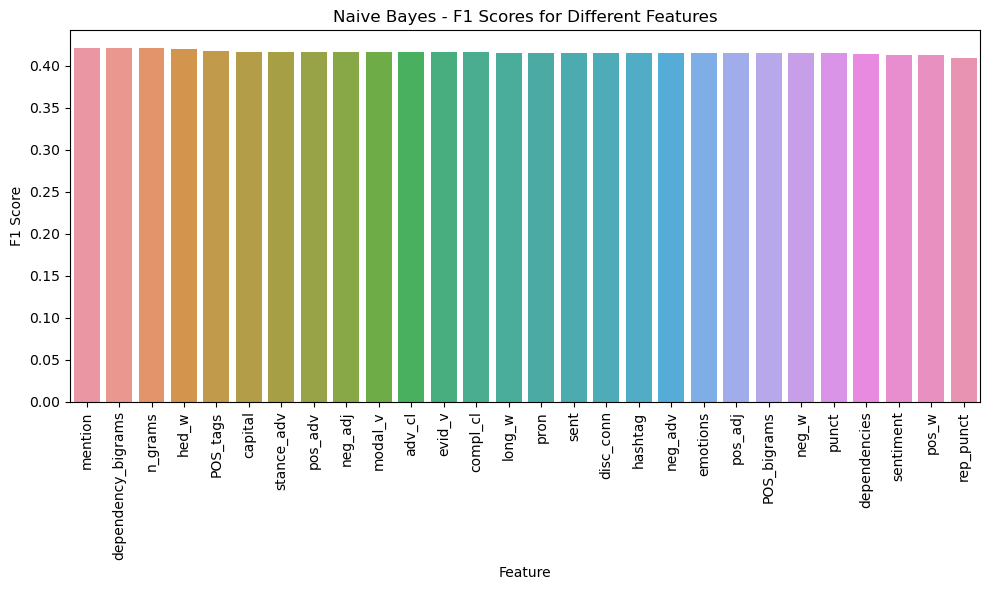

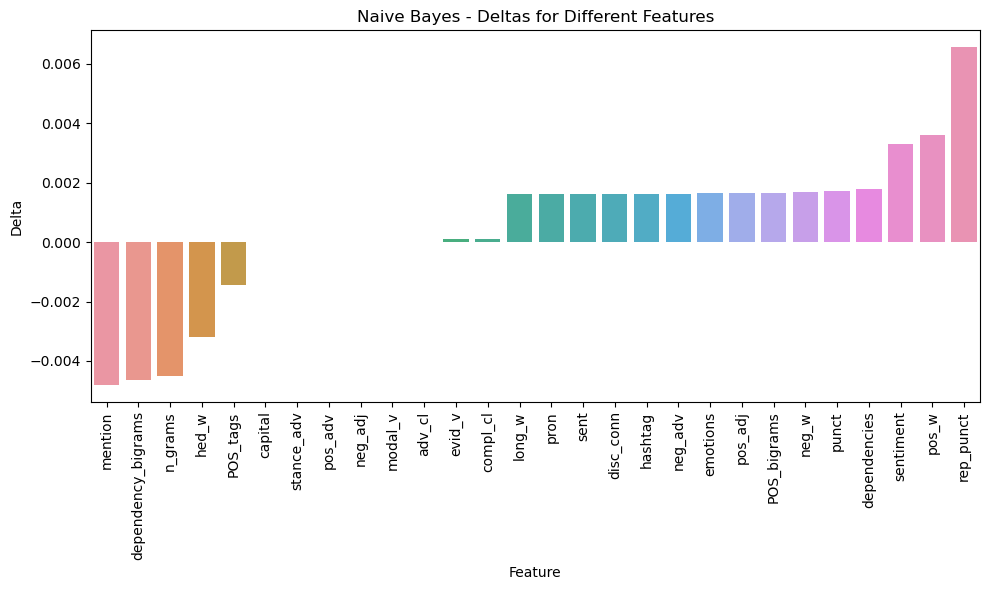

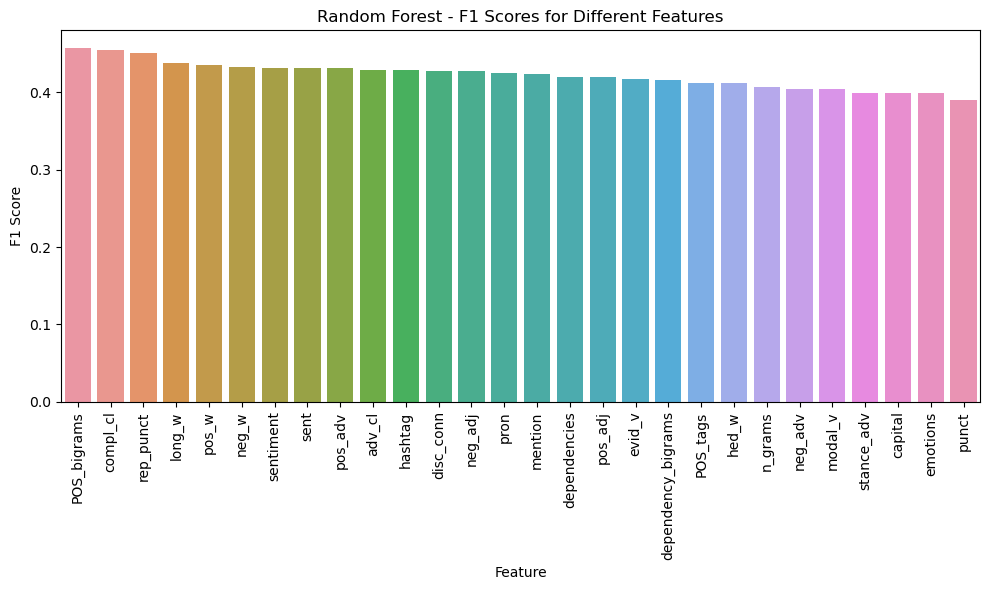

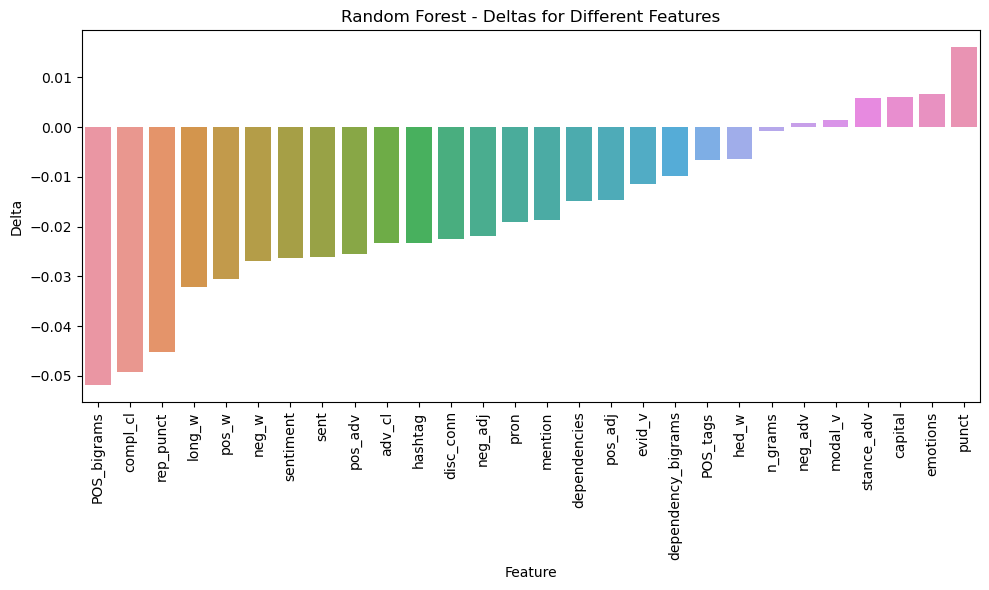

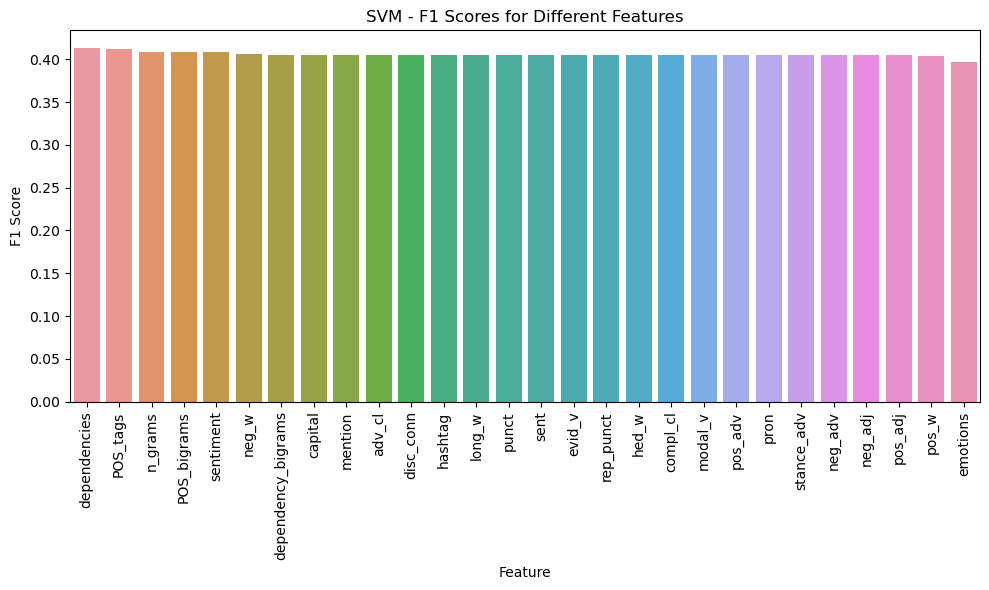

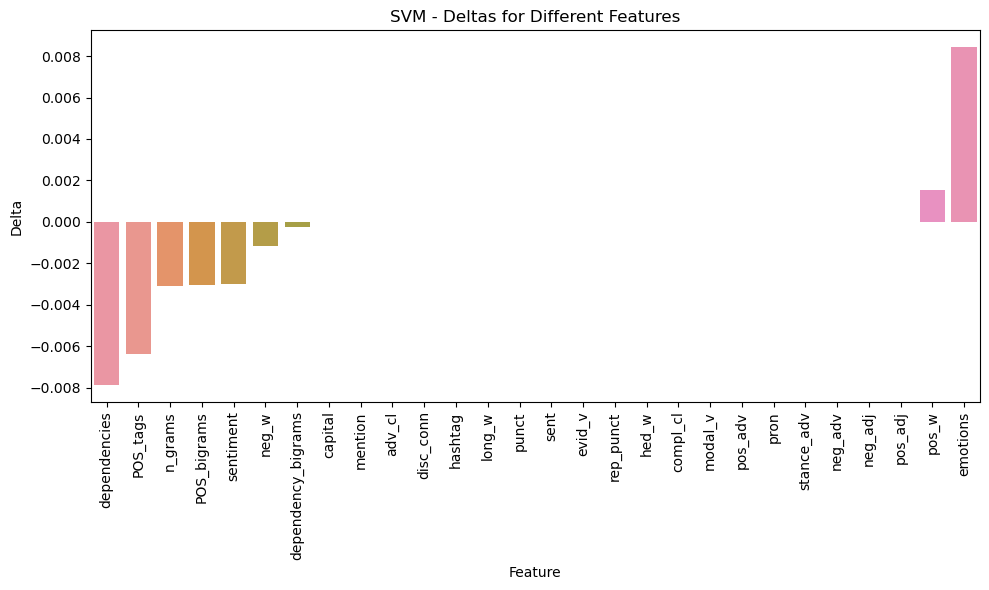

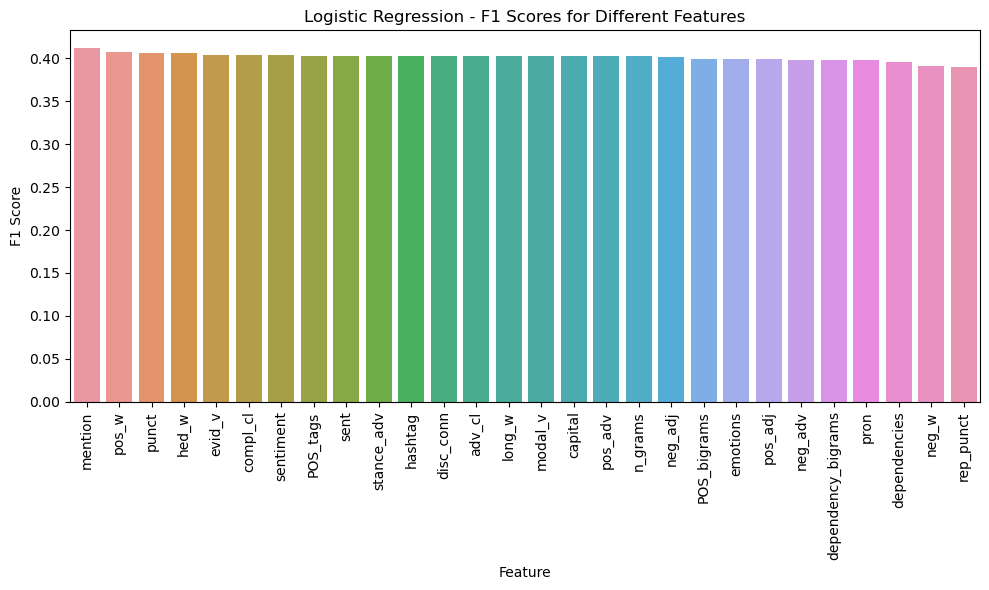

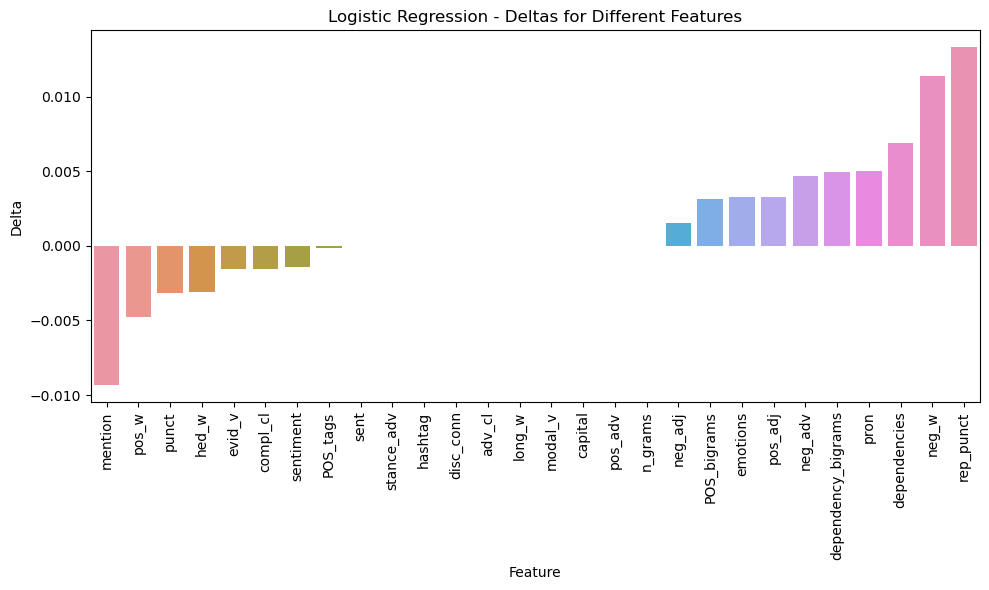

In [100]:
# Create separate graphs for each model
for model_name in model_names:
    # Filter the rows corresponding to the current model
    df_model = df_merged_sorted[df_merged_sorted['Model'] == model_name]
    
    # Plot F1 Scores
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Feature', y='F1 Score', data=df_model)
    plt.title(f'{model_name} - F1 Scores for Different Features')
    plt.xticks(rotation=90)
    plt.xlabel('Feature')
    plt.ylabel('F1 Score')
    plt.tight_layout()
    plt.show()
    
    # Plot Deltas
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Feature', y='Delta', data=df_model)
    plt.title(f'{model_name} - Deltas for Different Features')
    plt.xticks(rotation=90)
    plt.xlabel('Feature')
    plt.ylabel('Delta')
    plt.tight_layout()
    plt.show()

### By Linguistic Category - Ablation

In [101]:
X = grouped_features_lc

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

In [103]:
feature_names = features_lc


model_names = ['Naive Bayes', 'Random Forest', 'SVM', 'Logistic Regression']

# Make an empty dictionary to store the dataframes for each model
dfs = {}
 
# Iterate through the models
for model_name in model_names:
    result_list = []
    # Train and evaluate the full model
    if model_name == 'Naive Bayes':
        nb_model = MultinomialNB(alpha = 0.1)
        full_model = nb_model
    elif model_name == 'Random Forest':
        rfc_model = RandomForestClassifier(n_estimators=100, random_state=42)
        full_model = rfc_model
    elif model_name == 'SVM':
        svm_model = SVC(kernel='rbf')
        full_model = svm_model
    elif model_name == 'Logistic Regression':
        lr_model = LogisticRegression(C=1.0, penalty='l2', max_iter=10000, random_state=42)
        full_model = lr_model

    full_model.fit(X_train, y_train)
    y_pred_full = full_model.predict(X_test)
    f1_full = f1_score(y_test, y_pred_full, average='macro')
    
    # Iterate through the features
    for feature in feature_names:
        # Create a mask to exclude the current feature
        mask = np.ones(X.shape[1], dtype=bool)
        feature_index = feature_names.index(feature)
        mask[feature_index] = False

        # Perform ablation by removing the current feature  
        X_ablated = X[:, mask]

        # Split the ablated data into training and testing sets
        X_train_ablated, X_test_ablated, y_train, y_test = train_test_split(X_ablated, labels, test_size=0.2, random_state=42)

        # Train and evaluate the model on the ablated data
        if model_name == 'Naive Bayes':
            model_ablated = nb_model
        elif model_name == 'Random Forest':
            model_ablated = rfc_model
        elif model_name == 'SVM':
            model_ablated = svm_model
        elif model_name == 'Logistic Regression':
            model_ablated = lr_model
        
        model_ablated.fit(X_train_ablated, y_train)
        y_pred_ablated = model_ablated.predict(X_test_ablated)
        f1_ablated = f1_score(y_test, y_pred_ablated, average='macro')

        # Calculate the delta (difference)
        delta = f1_full - f1_ablated

        # Store the feature, F1 score, and delta in a list
        result_list.append((feature, f1_ablated, delta))
    
    # Create a dataframe for the model
    df_model = pd.DataFrame(result_list, columns=['Feature', 'F1 Score', 'Delta'])
    df_model['Model'] = model_name

    # Append the dataframe to the dictionary
    dfs[model_name] = df_model

# Concatenate the dataframes for all models
df_merged = pd.concat(dfs.values())

# Sort the DataFrame in descending order based on the F1 Score
#df_merged_sorted = df_merged.sort_values(by= 'F1 Score', ascending=False)

# Print the sorted merged dataframe
print(df_merged)

         Feature  F1 Score     Delta                Model
0        n_grams  0.419415  0.000000          Naive Bayes
1  morphological  0.417851  0.001564          Naive Bayes
2      pragmatic  0.417849  0.001566          Naive Bayes
3        lexical  0.414681  0.004734          Naive Bayes
4      syntactic  0.419415  0.000000          Naive Bayes
5     structural  0.416309  0.003106          Naive Bayes
0        n_grams  0.419384 -0.011923        Random Forest
1  morphological  0.429410 -0.021949        Random Forest
2      pragmatic  0.436290 -0.028829        Random Forest
3        lexical  0.408094 -0.000632        Random Forest
4      syntactic  0.424744 -0.017283        Random Forest
5     structural  0.423986 -0.016524        Random Forest
0        n_grams  0.405286  0.000000                  SVM
1  morphological  0.405286  0.000000                  SVM
2      pragmatic  0.406827 -0.001541                  SVM
3        lexical  0.405286  0.000000                  SVM
4      syntact

#### To see which features were considered more relevant or less relevant with the Ablation method, the results are plotted below. The first plot shows the results accordint with the Delta scores and the second one shows the results according to the macro F1 scores.

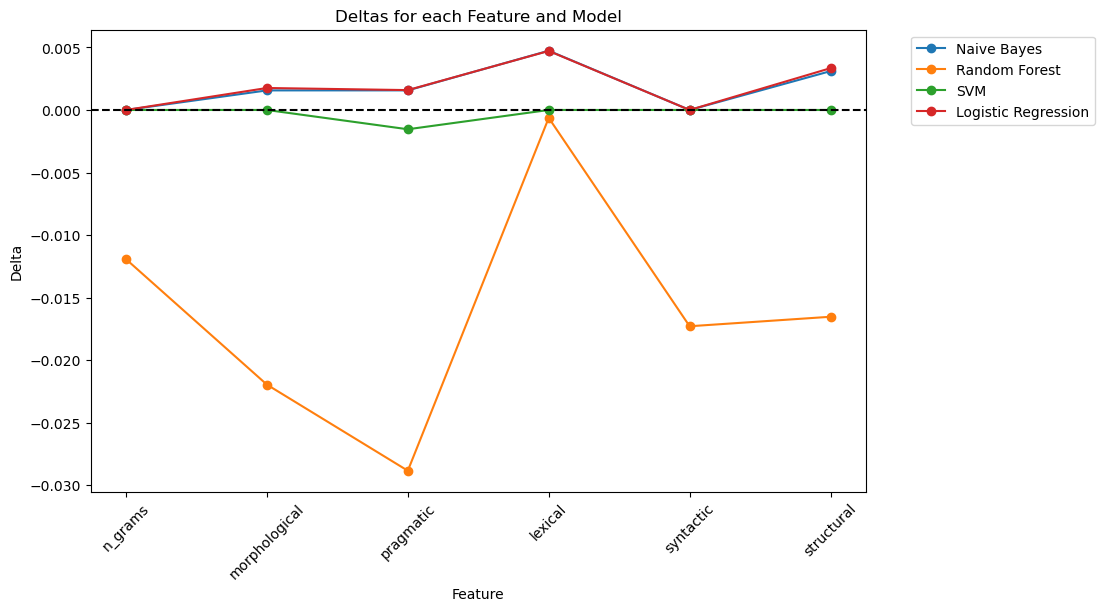

In [104]:
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(10, 6))

# Plot the deltas for each model and feature
for model in df_merged['Model'].unique():
    model_df = df_merged[df_merged['Model'] == model]
    plt.plot(model_df['Feature'], model_df['Delta'], marker='o', label=model)

# Add a line at the 0 axis
plt.axhline(y=0, color='black', linestyle='--')

# Add labels and title
plt.xlabel('Feature')
plt.ylabel('Delta')
plt.title('Deltas for each Feature and Model')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Add a legend
# Move the legend to the right
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

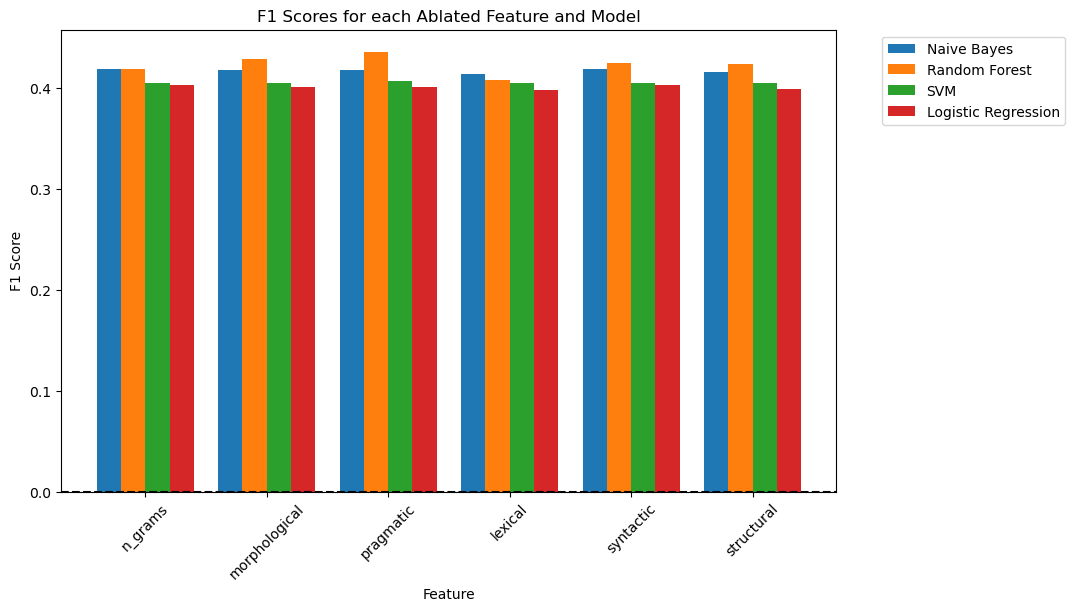

In [105]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Set the width of the bars
bar_width = 0.2

# Set the x-axis positions for each bar
x_pos = np.arange(len(df_merged['Feature'].unique()))

# Plot the F1 scores for each model and feature
for i, model in enumerate(df_merged['Model'].unique()):
    model_df = df_merged[df_merged['Model'] == model]
    plt.bar(x_pos + i * bar_width, model_df['F1 Score'], width=bar_width, label=model)

# Add a line at the 0 axis
plt.axhline(y=0, color='black', linestyle='--')

# Add labels and title
plt.xlabel('Feature')
plt.ylabel('F1 Score')
plt.title('F1 Scores for each Ablated Feature and Model')

# Set the x-axis tick positions and labels
plt.xticks(x_pos + bar_width * (len(df_merged['Model'].unique()) - 1) / 2, df_merged['Feature'].unique(), rotation=45)

# Move the legend to the right
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show

### Train the models individually without the features that are less relevant (determined by the Ablation method)

#### NB model:
nb_model = MultinomialNB(alpha = 0.1)

nb_model.fit(X_train, y_train)

y_pred = nb_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

report = classification_report(y_test, y_pred)

print(cm)

print(report)



#### RF model:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42) #select 100 dicision trees

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

report = classification_report(y_test, y_pred)

print(cm)

print(report)

#### LR model:
lr_model = LogisticRegression(C=1.0, penalty='l2', max_iter=10000, random_state=42)

lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

report = classification_report(y_test, y_pred)

print(cm)

print(report)

#### SVM model:
svm_model = SVC(kernel='rbf')

svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

report = classification_report(y_test, y_pred)

print(cm)

print(report)

## Correlation

#### First, one has to find which features are considered highly correlated withinh the individual features grouping, and then they are dropped from the X (the individual features),so that the models can be retrained without them. 

In [106]:
X = ind_features

In [107]:
# Make a copy of the original dataset
X_corr = X.copy()

# Calculate the correlation matrix
correlation_matrix = X_corr.corr()

# Find the highly correlated features
highly_correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.7 or abs(correlation_matrix.iloc[i, j]) < -0.7:
            # Add both features to the set
            feature_i = correlation_matrix.columns[i]
            feature_j = correlation_matrix.columns[j]
            highly_correlated_features.add(feature_i)
            highly_correlated_features.add(feature_j)

# Remove the highly correlated features from the copied dataset
X_corr.drop(columns=highly_correlated_features, inplace=True) #the X_corr can be used now without any highly correlated features

# Print the highly correlated features
print("Highly Correlated Features:")
for feature in highly_correlated_features:
    print(feature) #check for all the features that are highly correlated

Highly Correlated Features:
compound
Other
prep
new_evidential_verbs_count
new_stance_adverb_ratio
aux_neg
TO_VB
capital_ratios
nsubjpass
prep_poss
mark_nsubj
Adverb
negative_adv_ratio
auxpass
mention_count
count_adv_clause
new_evidential_verbs_ratio
neg
god bless
mention_ratio
discourse_connectives_ratio
det
positive_word_ratio
complement_clause_count
pobj
ccomp
DT_JJ
discourse_connectives_count
pronouns_ratio
positive_word_count
positive_adv_count
pronoun_count
best your
MD_VB
IN_PRP$
positive_adj_ratio
PRP$_NN
det_amod
new_stance_adv_count
relcl
compound_compound
prep_det
complement_clause_ratio
capital_counts
ratio_adv_clause
advmod
positive_adv_ratio
conj
mark
Determiner
bless you
know what
positive_adj_count
new_hedging_words_count
negative_adj_count
modal_verbs_count
negative_adj_ratio
negative_adv_count
cc
advcl
hashtag_ratio
negative_word_count
det_pobj
hashtag_count
IN_DT
xcomp
nsubj_relcl
modal_verbs_ratio
new_hedging_words_ratio
nsubj_ccomp
negative_word_ratio
DT_NN
poss
au

In [108]:
def train_model_and_evaluate_corr(model_type, features, labels):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    
    if model_type == 'NB':
        # Train Naive Bayes model with grid search for alpha
        nb_model = MultinomialNB(alpha = 0.1)
    
        
    elif model_type == 'RF':
        # Train Random Forest model
        rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
        rf_model.fit(X_train, y_train)
        y_pred = rf_model.predict(X_test)
    
    elif model_type == 'LR':
        # Train Logistic Regression model
        lr_model = LogisticRegression(C=1.0, penalty='l2', max_iter=10000, random_state=42)
        lr_model.fit(X_train, y_train)
        y_pred = lr_model.predict(X_test)
    
    elif model_type == 'SVM':
        # Train Support Vector Machine model with RBF kernel
        svm_model = SVC(kernel='rbf')
        svm_model.fit(X_train, y_train)
        y_pred = svm_model.predict(X_test)
    
    else:
        raise ValueError("Invalid model_type. Supported options: 'NB', 'RF', 'LR', 'SVM'")
    
    # Calculate confusion matrix and classification report
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    return cm, report


confusion_matrix_nb, classification_report_nb = train_model_and_evaluate('NB', X_corr, labels)
print("Confusion Matrix NB:")
print(confusion_matrix_nb)
print("\nClassification Report NB:")
print(classification_report_nb)

confusion_matrix_rf, classification_report_rf = train_model_and_evaluate('RF', X_corr, labels)
print("Confusion Matrix RF:")
print(confusion_matrix_rf)
print("\nClassification Report RF:")
print(classification_report_rf)

confusion_matrix_lr, classification_report_lr = train_model_and_evaluate('LR', X_corr, labels)
print("Confusion Matrix LR:")
print(confusion_matrix_lr)
print("\nClassification Report LR:")
print(classification_report_lr)

confusion_matrix_svm, classification_report_svm = train_model_and_evaluate('SVM', X_corr, labels)
print("Confusion Matrix SVM:")
print(confusion_matrix_svm)
print("\nClassification Report SVM:")
print(classification_report_svm)

Confusion Matrix NB:
[[61 60 56]
 [64 92 69]
 [64 69 87]]

Classification Report NB:
              precision    recall  f1-score   support

           0       0.32      0.34      0.33       177
           1       0.42      0.41      0.41       225
           2       0.41      0.40      0.40       220

    accuracy                           0.39       622
   macro avg       0.38      0.38      0.38       622
weighted avg       0.39      0.39      0.39       622

Confusion Matrix RF:
[[ 60  60  57]
 [ 57 112  56]
 [ 56  80  84]]

Classification Report RF:
              precision    recall  f1-score   support

           0       0.35      0.34      0.34       177
           1       0.44      0.50      0.47       225
           2       0.43      0.38      0.40       220

    accuracy                           0.41       622
   macro avg       0.41      0.41      0.41       622
weighted avg       0.41      0.41      0.41       622

Confusion Matrix LR:
[[ 78  53  46]
 [ 62 101  62]
 [ 70  6

#### The feature relevance is plotted in order to see which what type of features are left after the highly correlated ones were taken away.

In [109]:
# Create a dictionary to plot the feature types that are more relevant and less relevant
feature_groups_names = {'n_grams': ["user user","you don","years ago","you know","gamergate set","know what","what best","you want","user don","your life","don want","they re","laughing loud","you can","you re","you need","user set","climate change","feminist set","we need","we re","you set","user you","global warming","wakeupamerica set","don know","trot set", "user we","lovewins set","it set","you not","axillary clinton","user not","need feminist","can even","women rights","ha ha","equality set","thank you","democracy goal","equal rights","we should","regards peace","us set","you love","tea party","best your","don like","yesallwomen set","we must","bless you","god set","freethinker set","god bless","user thanks","they don","you much","no one","prochoice set","pro choice"],
'morphological' : ['IN_NNS', 'NNS_VBP', 'VBN_IN', 'IN_JJ', 'JJ_JJ', 'JJ_NN', 'NN_IN', 'IN_DT', 'DT_NNS', 'NNS_IN', 'JJ_NNS', 'JJ_IN', 'DT_NN', 'NN_NN', 'IN_VBG', 'TO_VB', 'VB_NN', 'NN_VBG', 'NN_RB', 'RB_IN', 'IN_NN', 'NN_CD', 'MD_VB', 'CD_NN', 'RB_RB', 'NNS_VBD', 'VB_JJ', 'VB_IN', 'RB_VB', 'VB_DT', 'NN_CC', 'CC_NN', 'NN_TO', 'NN_VBP', 'PRP_VBZ', 'IN_PRP', 'PRP_VBP', 'VBP_JJ', 'NN_MD', 'DT_JJ', 'NN_VBZ', 'VBZ_JJ', 'VBZ_DT', 'NN_VBN', 'RB_JJ', 'PRP$_NN', 'IN_PRP$', 'NN_NNS', 'VBP_NN', 'VBP_DT', 'NN_DT', 'NN_JJ', 'NN_PRP', 'VB_PRP', 'NNS_RB', 'VBP_IN', 'VBZ_RB', 'VBG_NN', 'NN_VBD', 'VBP_RB', "Preposition/Conjunction","Noun","Verb","Adjective","Determiner","Pronoun","Other","Adverb"],
'pragmatic' : ['positive_word_count', 'positive_word_ratio', 'negative_word_count', 'negative_word_ratio', 'sentiment', '1', '2', '3', '4', '5', '6', '7', '8'],
'lexical' : ['new_stance_adverb_ratio', 'new_stance_adv_count', 'pronoun_count', 'pronouns_ratio', 'modal_verbs_count', 'modal_verbs_ratio', 'new_evidential_verbs_count', 'new_evidential_verbs_ratio', 'new_hedging_words_count', 'new_hedging_words_ratio', 'positive_adv_count', 'positive_adv_ratio', 'positive_adj_count', 'positive_adj_ratio','negative_adj_count', 'negative_adj_ratio','negative_adv_count', 'negative_adv_count'],
'syntactic' : ['complement_clause_ratio', 'complement_clause_count', 'ratio_adv_clause', 'count_adv_clause', 'mark', 'nsubjpass', 'auxpass', 'ROOT', 'prep', 'punct', 'amod', 'cc', 'conj', 'det', 'pobj', 'advcl', 'appos', 'compound', 'nsubj', 'pcomp', 'aux', 'xcomp', 'dobj', 'advmod', 'nummod', 'acomp', 'ccomp', 'intj', 'neg', 'preconj', 'relcl', 'prt', 'agent', 'npadvmod', 'poss', 'case', 'nmod', 'attr', 'expl', 'acl', 'csubj', 'dative', 'predet', 'oprd', 'dep', 'parataxis', 'meta', 'quantmod', 'csubjpass',  "ROOT_punct","nsubj_ROOT","pobj_punct","prep_pobj","compound_compound","punct_ROOT","nsubj_aux","dobj_punct","prep_det","punct_nsubj","dobj_prep","punct_compound","compound_ROOT","nsubj_ccomp","det_amod","compound_nsubj","ROOT_det","compound_pobj","pobj_prep","det_pobj","ROOT_prep","aux_xcomp","det_dobj","aux_neg","ROOT_dobj","compound_dobj","amod_pobj","cc_conj","mark_nsubj","aux_ROOT","amod_dobj","amod_compound","punct_punct","nsubj_advcl","det_nsubj","attr_punct","amod_nsubj","advmod_ROOT","prep_compound","ROOT_nsubj","ROOT_advmod","prep_poss","det_compound","advmod_punct","nsubj_relcl","advmod_nsubj","punct_amod","conj_punct","neg_ROOT","punct_advmod","prep_amod","nsubj_advmod","det_attr","acomp_punct","advmod_advmod","ROOT_acomp","ccomp_punct","ROOT_aux","amod_ROOT","nsubj_prep"],
'structural' : ['discourse_connectives_ratio', 'discourse_connectives_count', 'hashtag_ratio', 'hashtag_count', 'mention_ratio', 'mention_count', 'punctuation_ratio', 'sentence_length', 'long_word_ratio', 'repeated_punctuation_ratio', 'capital_counts', 'capital_ratios']}

In [110]:
def plot_feature_importance(X, feature_groups, model_name):
    # Calculate the average feature importance across all utterances
    feature_importance = np.mean(X.values, axis=0)

    # Create a dictionary to store the cumulative importance for each group
    group_importance = {}

    # Sum the importance scores for each group
    for feature, importance in zip(X.columns, feature_importance):
        # Find the matching group for the feature
        group = None
        for group_name, group_features in feature_groups.items():
            if feature in group_features:
                group = group_name
                break
        if group is None:
            group = 'Other'
        
        if group not in group_importance:
            group_importance[group] = 0.0
        group_importance[group] += importance

    # Get the group names and cumulative importance values
    group_names = list(group_importance.keys())
    cumulative_importance = list(group_importance.values())

    # Create a bar chart
    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
    plt.bar(range(len(cumulative_importance)), cumulative_importance)
    plt.xticks(range(len(cumulative_importance)), group_names, rotation='vertical')
    plt.xlabel('Feature Group')
    plt.ylabel('Frequency')
    plt.title(f'Feature Distribution by Feature Group for {model_name}')
    plt.tight_layout()  # Adjust the spacing to prevent overlapping labels
    plt.xticks(rotation=40)  # Rotate the x-axis labels for better readability
    plt.show()

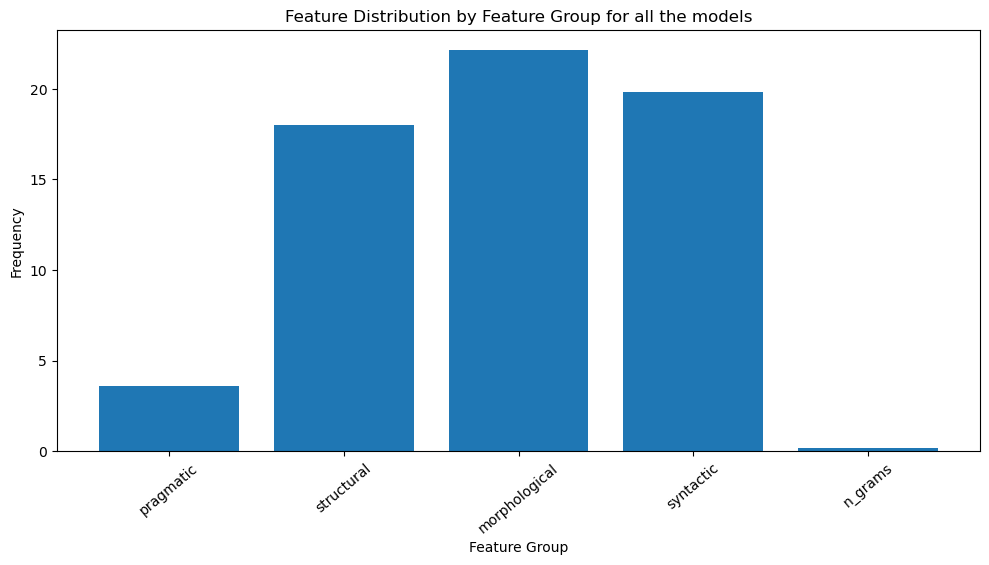

In [111]:
plot_feature_importance(X_corr, feature_groups_names, model_name = 'all the models')

## RFECV 

#### The RFECV test is now applied to the models RF, LR and SVM only. The test will be applied on the individual features grouping type.

In [112]:
from sklearn.feature_selection import RFECV
y = labels
X = ind_features

lr_model = LogisticRegression(C=1.0, penalty='l2', max_iter=10000, random_state=42)
svm_model = SVC(kernel='linear')  # the kernel is chnaged to 'linear', since the 'rbf' one doesn't work. 
rfc_model = RandomForestClassifier(n_estimators=100, random_state=42)

def rfecv_feature_selection(estimator, X, y, cv=5):
    selector = RFECV(estimator=estimator, step=1, cv=cv, scoring='f1_macro')
    selector.fit(X, y)
    selected_features = X.columns[selector.support_]
    X_selected = X[selected_features]
    return X_selected

In [113]:
X_selected_RF = rfecv_feature_selection(rfc_model, X, y)

In [114]:
X_selected_LR = rfecv_feature_selection(lr_model, X, y)

In [115]:
X_selected_SVM = rfecv_feature_selection(svm_model, X, y)

### RF - RFECV

In [116]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected_RF, labels, test_size=0.2, random_state=42)

results = rfc_model.fit(X_train, y_train)

y_pred = rfc_model.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
# Evaluate the performance of the model
print(conf_mat)

clas_rep = classification_report(y_test, y_pred)
print(clas_rep) #Check the evaluation metrics.

[[ 74  58  45]
 [ 60 108  57]
 [ 53  64 103]]
              precision    recall  f1-score   support

           0       0.40      0.42      0.41       177
           1       0.47      0.48      0.47       225
           2       0.50      0.47      0.48       220

    accuracy                           0.46       622
   macro avg       0.46      0.46      0.46       622
weighted avg       0.46      0.46      0.46       622



In [117]:
len(X_selected_RF.columns)

204

In [118]:
for column in X_selected_RF:
    print(column)

sentiment
complement_clause_count
positive_word_count
negative_word_count
pronoun_count
modal_verbs_count
new_evidential_verbs_count
positive_word_ratio
negative_word_ratio
pronouns_ratio
modal_verbs_ratio
new_evidential_verbs_ratio
positive_adj_count
negative_adj_count
sentence_length
hashtag_count
mention_count
negative_adj_ratio
positive_adj_ratio
punctuation_ratio
discourse_connectives_count
discourse_connectives_ratio
new_stance_adverb_ratio
repeated_punctuation_ratio
long_word_ratio
hashtag_ratio
mention_ratio
new_hedging_words_count
new_hedging_words_ratio
count_adv_clause
capital_counts
capital_ratios
complement_clause_ratio
ratio_adv_clause
1
2
3
4
5
6
7
8
Preposition/Conjunction
Noun
Verb
Adjective
Determiner
Pronoun
Other
Adverb
IN_NNS
NNS_VBP
VBN_IN
IN_JJ
JJ_JJ
JJ_NN
NN_IN
IN_DT
DT_NNS
NNS_IN
JJ_NNS
JJ_IN
DT_NN
NN_NN
IN_VBG
TO_VB
VB_NN
NN_VBG
NN_RB
RB_IN
IN_NN
NN_CD
MD_VB
CD_NN
RB_RB
NNS_VBD
VB_JJ
VB_IN
RB_VB
VB_DT
NN_CC
CC_NN
NN_TO
NN_VBP
PRP_VBZ
IN_PRP
PRP_VBP
VBP_JJ
NN_M

### LR - RFECV

In [119]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected_LR,y, test_size=0.2, random_state=42)

# Fit the model on the training set
results = lr_model.fit(X_train, y_train)

# Predict the stance labels for the testing set
y_pred = lr_model.predict(X_test)

# Evaluate the performance of the model
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)

clas_rep = classification_report(y_test, y_pred)
print(clas_rep) #Check the evaluation metrics.

[[ 81  54  42]
 [ 65 103  57]
 [ 69  64  87]]
              precision    recall  f1-score   support

           0       0.38      0.46      0.41       177
           1       0.47      0.46      0.46       225
           2       0.47      0.40      0.43       220

    accuracy                           0.44       622
   macro avg       0.44      0.44      0.43       622
weighted avg       0.44      0.44      0.44       622



### SVM - RFECV

In [120]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected_SVM, labels, test_size=0.2, random_state=42)

# Create an SVM classifier
svm = SVC(kernel='rbf') # the kernel is changed back to 'rbf'

# Train the SVM classifier
svm.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm.predict(X_test)

# Evaluate the performance of the model
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)

clas_rep = classification_report(y_test, y_pred)
print(clas_rep) #Check the evaluation metrics

[[ 71  59  47]
 [ 58 115  52]
 [ 70  56  94]]
              precision    recall  f1-score   support

           0       0.36      0.40      0.38       177
           1       0.50      0.51      0.51       225
           2       0.49      0.43      0.46       220

    accuracy                           0.45       622
   macro avg       0.45      0.45      0.45       622
weighted avg       0.45      0.45      0.45       622



#### The feature relevance is plotted in order to see which what type of features are more relevant and less relevant. 

In [121]:
def plot_feature_importance(X, feature_groups, model_name):
    # Calculate the average feature importance across all sentences
    feature_importance = np.mean(X.values, axis=0)

    # Create a dictionary to store the cumulative importance for each group
    group_importance = {}

    # Sum the importance scores for each group
    for feature, importance in zip(X.columns, feature_importance):
        # Find the matching group for the feature
        group = None
        for group_name, group_features in feature_groups.items():
            if feature in group_features:
                group = group_name
                break
        if group is None:
            group = 'Other'
        
        if group not in group_importance:
            group_importance[group] = 0.0
        group_importance[group] += importance

    # Get the group names and cumulative importance values
    group_names = list(group_importance.keys())
    cumulative_importance = list(group_importance.values())

    # Make a bar chart
    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
    plt.bar(range(len(cumulative_importance)), cumulative_importance)
    plt.xticks(range(len(cumulative_importance)), group_names, rotation='vertical')
    plt.xlabel('Feature Group')
    plt.ylabel('Frequency')
    plt.title(f'Feature Distribution by Feature Group for {model_name}')
    plt.tight_layout()  # Adjust the spacing to prevent overlapping labels
    plt.xticks(rotation=40)  # Rotate the x-axis labels for better readability
    plt.show()

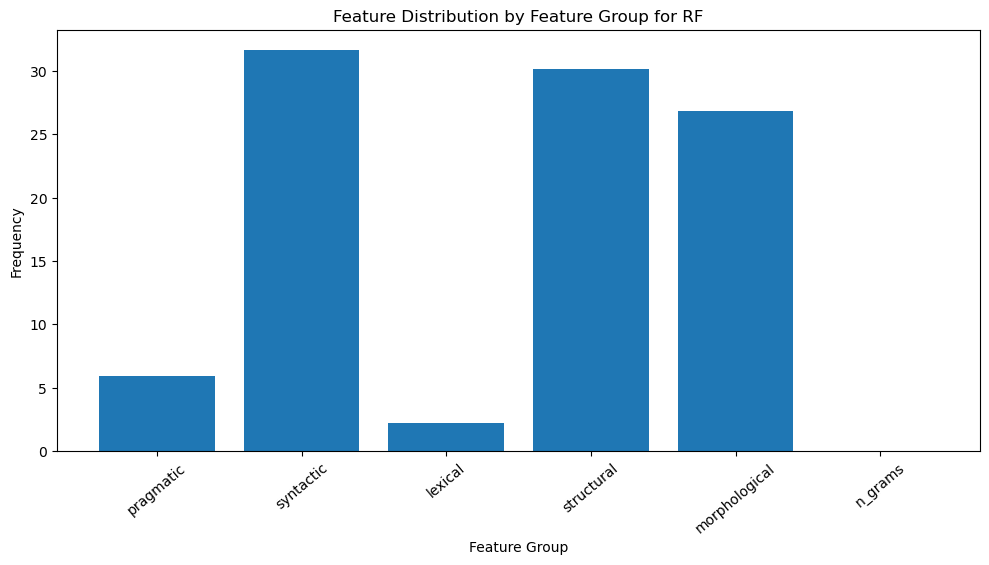

In [122]:
plot_feature_importance(X_selected_RF, feature_groups_names, model_name = 'RF')

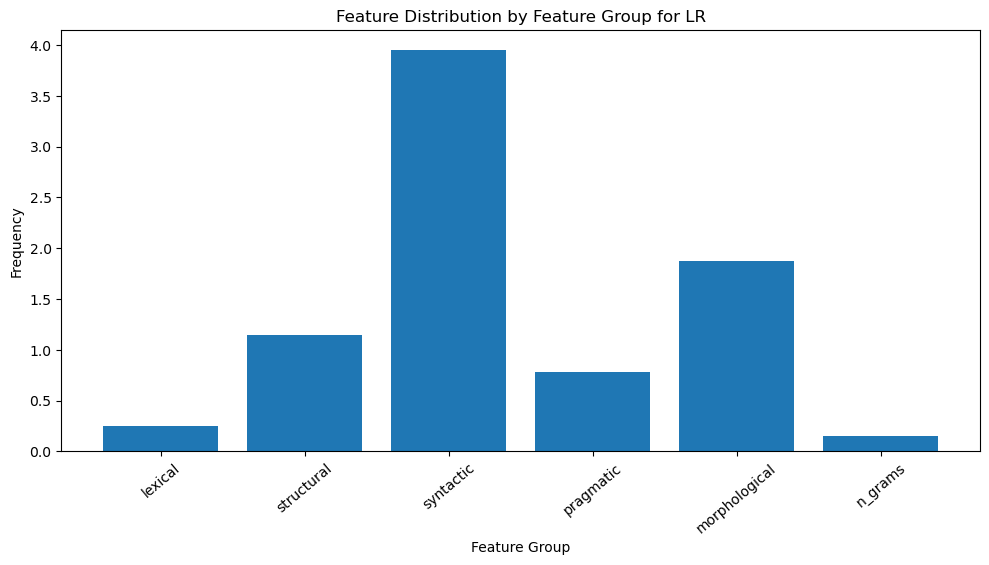

In [123]:
plot_feature_importance(X_selected_LR, feature_groups_names, model_name = 'LR')

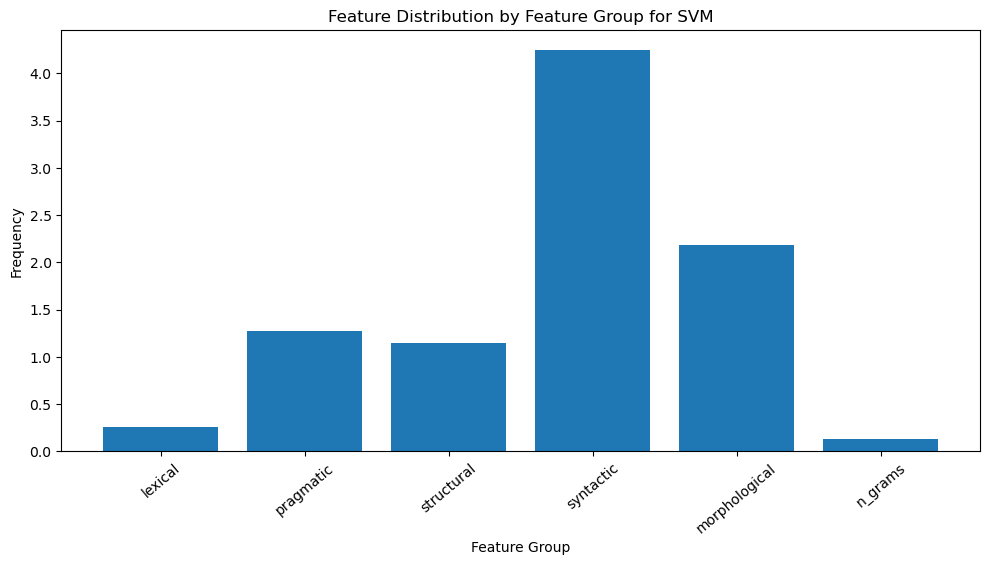

In [124]:
plot_feature_importance(X_selected_SVM, feature_groups_names, model_name = 'SVM')

## Feature Log-Probabilities

#### With this feature importance method, one can check for the NB model which features play a relevant role on each one of the labels. 

In [125]:
X = ind_features

In [126]:
# Train Naive Bayes model with grid search for alpha
nb_model = MultinomialNB(alpha = 0.1)
        
X_train, X_test, y_train, y_test = train_test_split(ind_features, labels, test_size=0.2, random_state=42)

# Perform the grid search on the training data
nb_model.fit(X_train, y_train)
    
# Train the Naive Bayes model with the best alpha value found during the grid search
y_pred = nb_model.predict(X_test)

# Access the feature probabilities
feature_log_probabilities_NB = nb_model.feature_log_prob_
feature_probabilities_NB = np.exp(feature_log_probabilities_NB)

if len(feature_probabilities_NB) == 1:
    feature_probabilities_NB = feature_probabilities_NB[0]
feature_probabilities_NB_df = pd.DataFrame(feature_probabilities_NB, columns = X.columns )

#### To see which feature groups were more more relevant and less relevant, they the feature probabilities are plotted below.

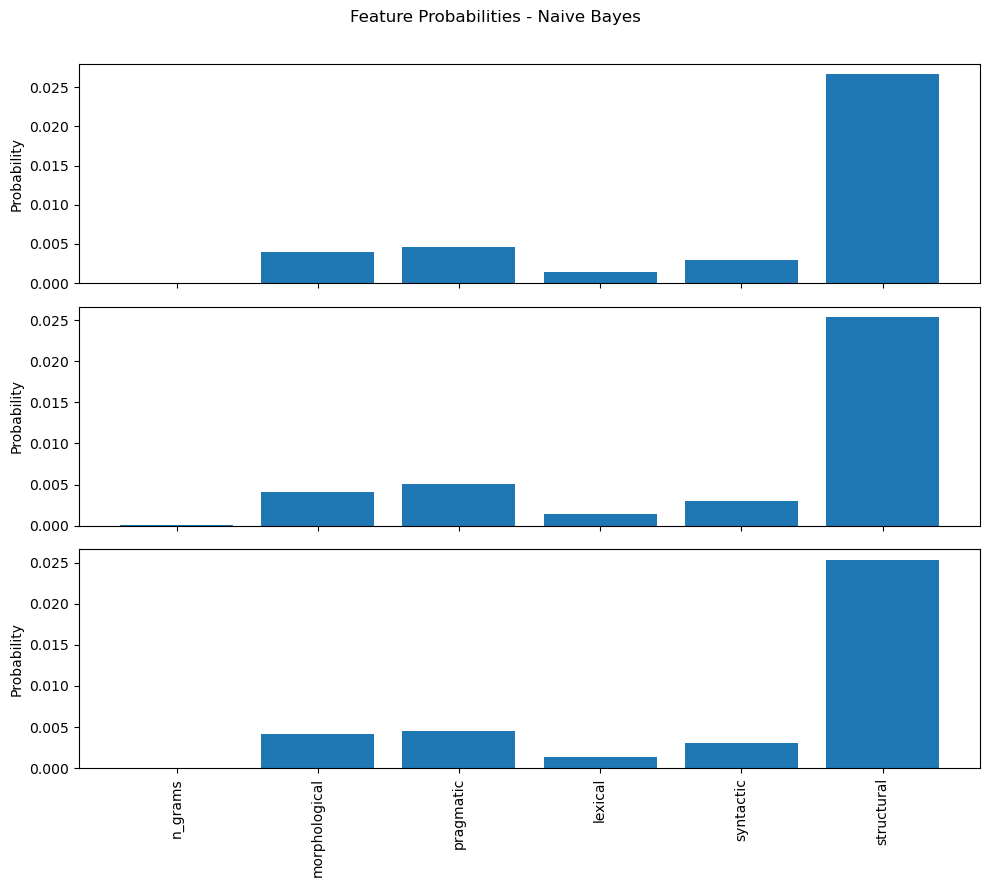

In [127]:
import matplotlib.pyplot as plt

# Plotting function
def plot_feature_probabilities_NB(feature_probabilities, feature_groups, model_name):
    num_features = len(feature_probabilities.columns)
    num_classes = len(feature_probabilities)

    # Set up the figure and axes
    fig, axes = plt.subplots(num_classes, 1, figsize=(10, num_classes * 3), sharex=True)

    # Iterate over the classes and plot the feature probabilities
    for i, ax in enumerate(axes):
        grouped_probabilities = []
        grouped_labels = []

        for group, features in feature_groups.items():
            group_probabilities = feature_probabilities.loc[i, features]
            grouped_probabilities.append(group_probabilities.mean())
            grouped_labels.append(group)

        ax.bar(range(len(grouped_labels)), grouped_probabilities)
        ax.set_xticks(range(len(grouped_labels)))
        ax.set_xticklabels(grouped_labels, rotation='vertical')
        ax.set_ylabel('Probability')
        

    # Set the overall title of the figure
    fig.suptitle(f'Feature Probabilities - {model_name}')

    # Adjust spacing between subplots
    fig.tight_layout(rect=[0, 0, 1, 0.97])

    # Show the plot
    plt.show()

plot_feature_probabilities_NB(feature_probabilities_NB_df, feature_groups_names, 'Naive Bayes')

In [128]:
nb_features = dataf[[
    'sentiment',
    'complement_clause_count',
    'positive_word_count',
    'negative_word_count',
    'positive_word_ratio',
    'negative_word_ratio',
    'sentence_length',
    'hashtag_count',
    'mention_count',
    'punctuation_ratio',
    'discourse_connectives_count',
    'discourse_connectives_ratio', 
    'repeated_punctuation_ratio',
    'long_word_ratio',
    'hashtag_ratio',
    'mention_ratio',
    'count_adv_clause',
    'capital_counts',
    'capital_ratios',
    'complement_clause_ratio',
    'ratio_adv_clause',
    '1',
    '2',
    '3',
    '4',
    '5',
    '6',
    '7',
    '8',
    "Preposition/Conjunction",
    "Noun",
    "Verb",
    "Adjective",
    "Determiner",
    "Pronoun",
    "Other",
    "Adverb",
    'IN_NNS',
    'NNS_VBP',
    'VBN_IN',
    'IN_JJ',
    'JJ_JJ',
    'JJ_NN',
    'NN_IN',
    'IN_DT',
    'DT_NNS',
    'NNS_IN',
    'JJ_NNS',
    'JJ_IN',
    'DT_NN',
    'NN_NN',
    'IN_VBG',
    'TO_VB',
    'VB_NN',
    'NN_VBG',
    'NN_RB',
    'RB_IN',
    'IN_NN',
    'NN_CD',
    'MD_VB',
    'CD_NN',
    'RB_RB',
    'NNS_VBD',
    'VB_JJ',
    'VB_IN',
    'RB_VB',
    'VB_DT',
    'NN_CC',
    'CC_NN',
    'NN_TO',
    'NN_VBP',
    'PRP_VBZ',
    'IN_PRP',
    'PRP_VBP',
    'VBP_JJ',
    'NN_MD',
    'DT_JJ',
    'NN_VBZ',
    'VBZ_JJ',
    'VBZ_DT',
    'NN_VBN',
    'RB_JJ',
    'PRP$_NN',
    'IN_PRP$',
    'NN_NNS',
    'VBP_NN',
    'VBP_DT',
    'NN_DT',
    'NN_JJ',
    'NN_PRP',
    'VB_PRP',
    'NNS_RB',
    'VBP_IN',
    'VBZ_RB',
    'VBG_NN',
    'NN_VBD',
    'VBP_RB',
    'mark',
    'nsubjpass',
    'auxpass',
    'ROOT',
    'prep',
    'punct',
    'amod',
    'cc',
    'conj',
    'det',
    'pobj',
    'advcl',
    'appos',
    'compound',
    'nsubj',
    'pcomp',
    'aux',
    'xcomp',
    'dobj',
    'advmod',
    'nummod',
    'acomp',
    'ccomp',
    'intj',
    'neg',
    'preconj',
    'relcl',
    'prt',
    'agent',
    'npadvmod',
    'poss',
    'case',
    'nmod',
    'attr',
    'expl',
    'acl',
    'csubj',
    'dative',
    'predet',
    'oprd',
    'dep',
    'parataxis',
    'meta',
    'quantmod',
    'csubjpass',
    "ROOT_punct",
    "nsubj_ROOT",
    "pobj_punct",
    "prep_pobj",
    "compound_compound",
    "punct_ROOT",
    "nsubj_aux",
    "dobj_punct",
    "prep_det",
    "punct_nsubj",
    "dobj_prep",
    "punct_compound",
    "compound_ROOT",
    "nsubj_ccomp",
    "det_amod",
    "compound_nsubj",
    "ROOT_det",
    "compound_pobj",
    "pobj_prep",
    "det_pobj",
    "ROOT_prep",
    "aux_xcomp",
    "det_dobj",
    "aux_neg",
    "ROOT_dobj",
    "compound_dobj",
    "amod_pobj",
    "cc_conj",
    "mark_nsubj",
    "aux_ROOT",
    "amod_dobj",
    "amod_compound",
    "punct_punct",
    "nsubj_advcl",
    "det_nsubj",
    "attr_punct",
    "amod_nsubj",
    "advmod_ROOT",
    "prep_compound",
    "ROOT_nsubj",
    "ROOT_advmod",
    "prep_poss",
    "det_compound",
    "advmod_punct",
    "nsubj_relcl",
    "advmod_nsubj",
    "punct_amod",
    "conj_punct",
    "neg_ROOT",
    "punct_advmod",
    "prep_amod",
    "nsubj_advmod",
    "det_attr",
    "acomp_punct",
    "advmod_advmod",
    "ROOT_acomp",
    "ccomp_punct",
    "ROOT_aux",
    "amod_ROOT",
    "nsubj_prep"
   
]]

#### NB results without N-grams features

In [129]:
nb_model = MultinomialNB(alpha = 0.1)
#X_train, X_test, y_train, y_test = train_test_split(nb_features, labels, test_size=0.2, random_state=45) #split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(nb_features, labels, test_size=0.2, random_state=42)
nb_model.fit(X_train, y_train)
y_pred = nb_model.predict(X_test)

# Evaluate the performance of the model
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)

clas_rep = classification_report(y_test, y_pred)
print(clas_rep) #Check the evaluation metrics

[[83 45 49]
 [71 96 58]
 [74 69 77]]
              precision    recall  f1-score   support

           0       0.36      0.47      0.41       177
           1       0.46      0.43      0.44       225
           2       0.42      0.35      0.38       220

    accuracy                           0.41       622
   macro avg       0.41      0.42      0.41       622
weighted avg       0.42      0.41      0.41       622



## Error Analysis

#### The best result was obtained with the SVM model, so its predictions will now be plotted to acess which features are more contrastive between the two prediction types: Mispredictions and Predictions.

In [130]:
classified_df = pd.DataFrame(columns=X_selected_RF.columns)  

for i in range(len(y_pred)):
    instance = X_selected_RF.iloc[i] 
    
    if y_pred[i] == y_test[i]:
        instance['Prediction'] = 1  # Correctly classified, assign 1
    else:
        instance['Prediction'] = 0  # Incorrectly classified, assign 0
    
    classified_df = classified_df.append(instance)

#print("Classified instances:")
#print(classified_df)

/tmp/ipykernel_20/3264204168.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  instance['Prediction'] = 0  # Incorrectly classified, assign 0
/tmp/ipykernel_20/3264204168.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  instance['Prediction'] = 0  # Incorrectly classified, assign 0
/tmp/ipykernel_20/3264204168.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  classified_df = classified_df.append(instance)
/tmp/ipykernel_20/3264204168.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

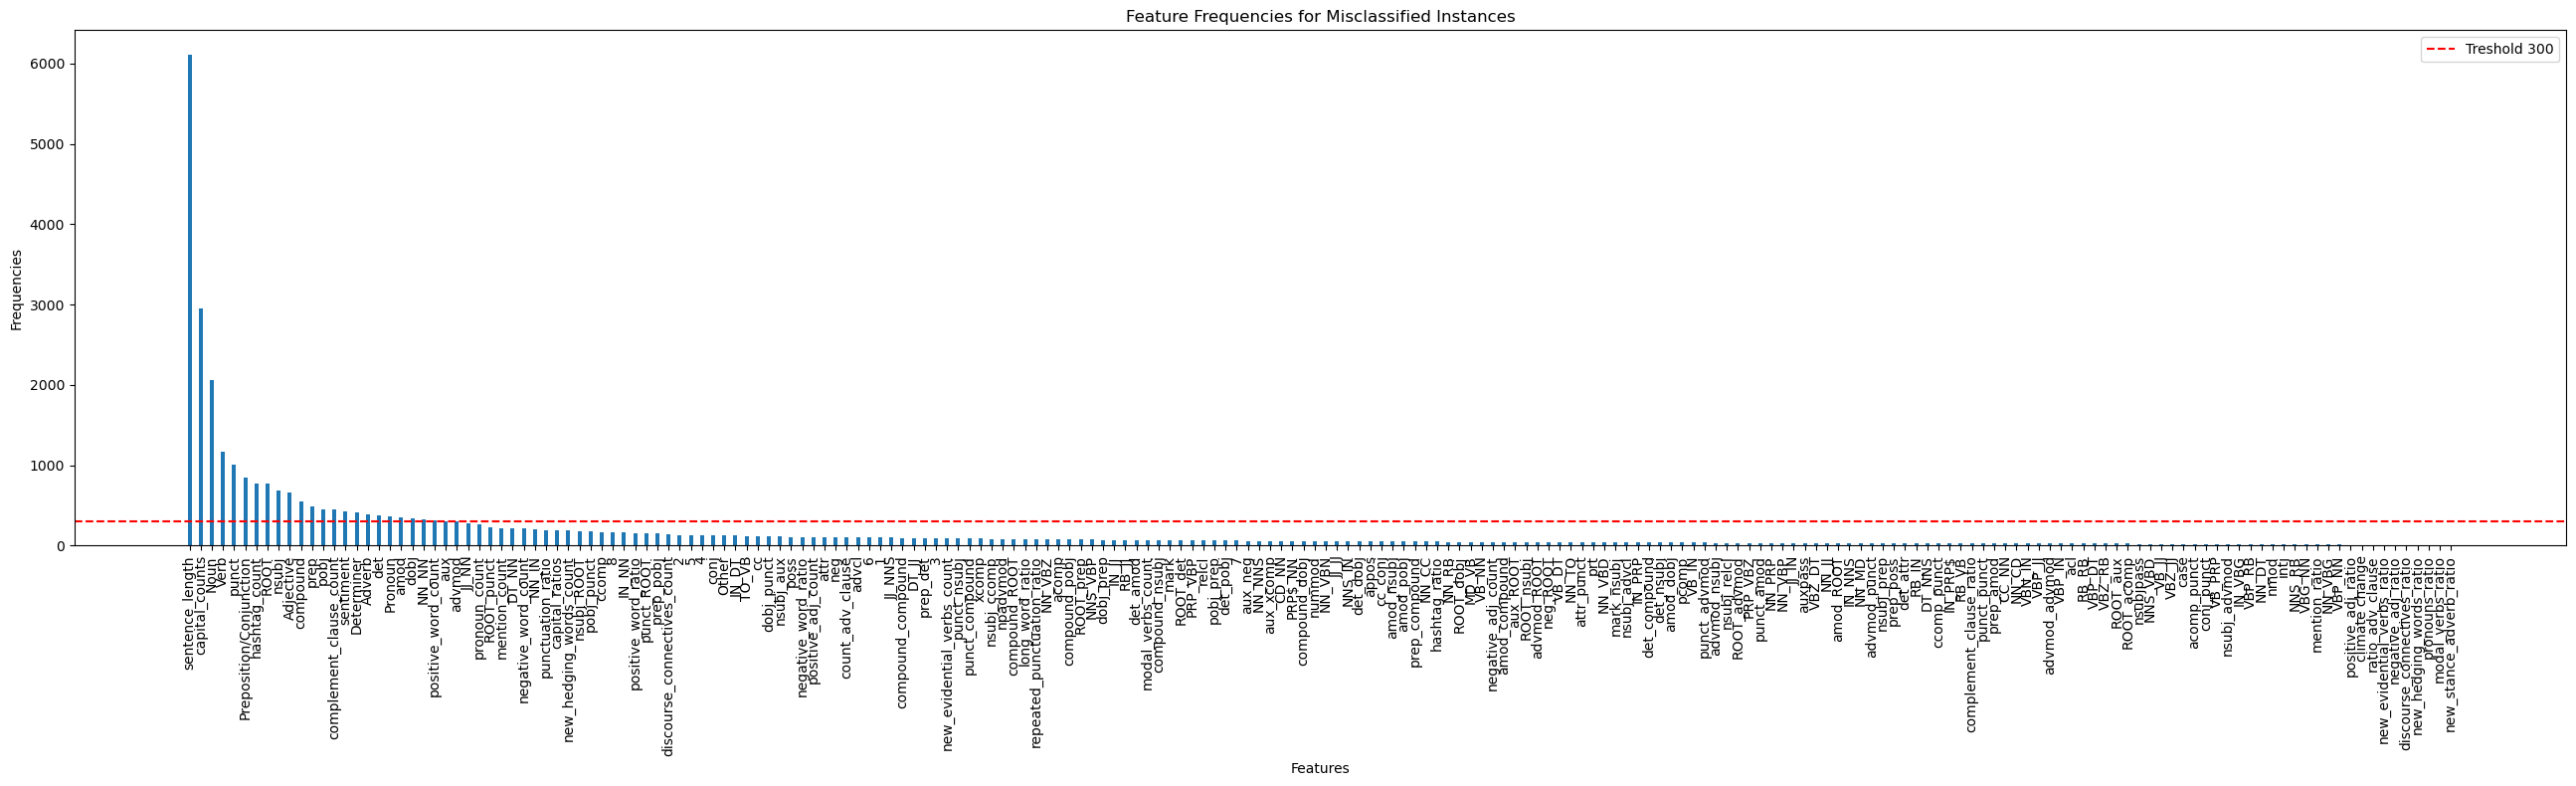

In [131]:
def plot_feature_frequencies(classified_df, prediction_column):
    # Filter misclassified instances from classified_df
    misclassified_df = classified_df[classified_df[prediction_column] == 0]

    # Get the frequencies of each feature for the misclassified instances
    misclassified_frequencies = misclassified_df.sum(axis=0)

    # Drop the prediction_column, as it is not needed
    misclassified_frequencies = misclassified_frequencies.drop(prediction_column)

    # Calculate the total occurrences in misclassified instances
    total_misclassified = len(misclassified_df)

    # Calculate the percentage of each feature's occurrences in misclassified instances
    percentage_misclassified = (misclassified_frequencies / total_misclassified) * 100

    # Sort the features by their frequency in misclassified instances in descending order
    incorrectly_classified_frequencies = misclassified_frequencies.sort_values(ascending=False)

    # Plot the frequencies as a bar plot
    plt.figure(figsize=(26, 8))
    width = 0.35
    x = range(len(incorrectly_classified_frequencies))

    # Plot the frequency of occurrences
    plt.bar(x, incorrectly_classified_frequencies, width)
    plt.xlabel('Features')
    plt.ylabel('Frequencies')
    plt.title('Feature Frequencies for Misclassified Instances')
    plt.xticks([i for i in x], incorrectly_classified_frequencies.index, rotation=90)
    
    plt.axhline(y=300, color='red', linestyle='--', label='Treshold 300')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_feature_frequencies(classified_df, 'Prediction')

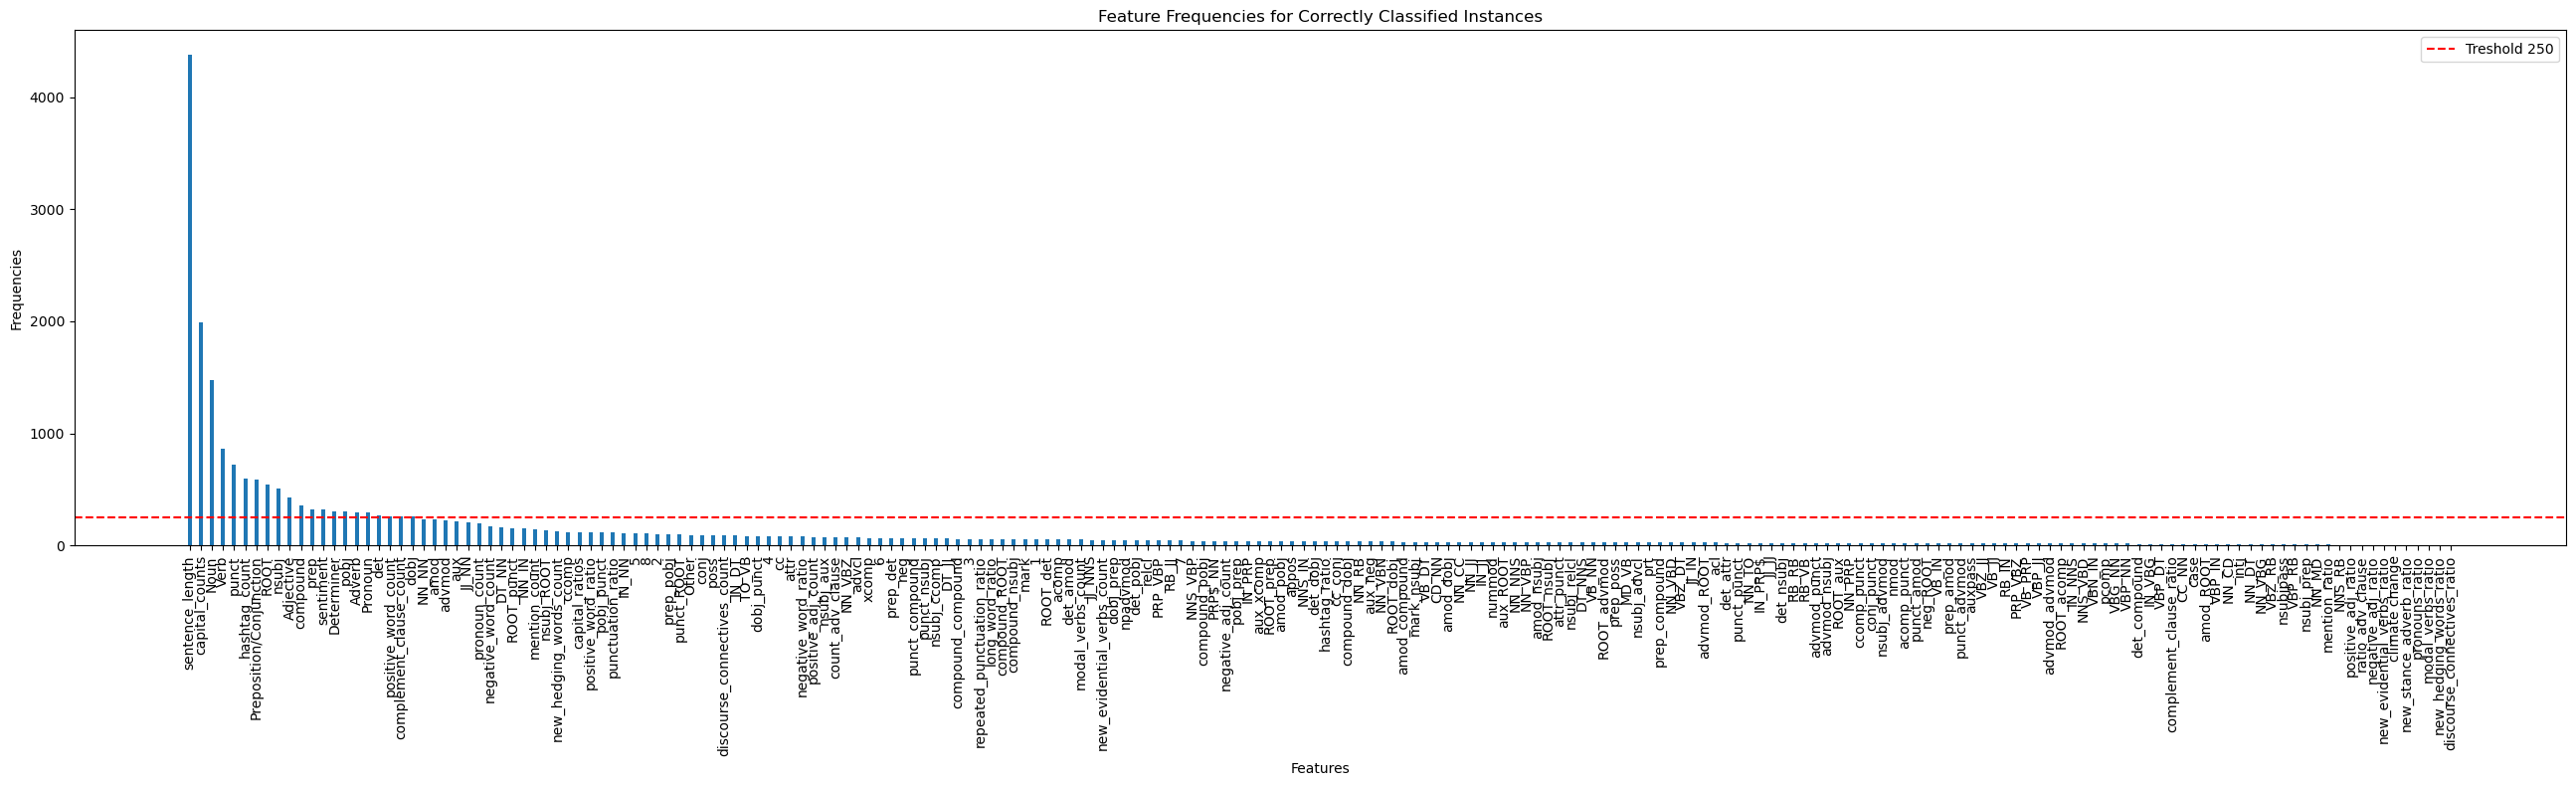

In [132]:
def plot_feature_frequencies_classified(classified_df, prediction_column):
    # Filter correctly classified instances from classified_df
    classified_df = classified_df[classified_df[prediction_column] == 1]

    # Get the frequencies of each feature for the correctly classified instances
    classified_frequencies = classified_df.sum(axis=0)

    # Drop the prediction_column, as it is not needed
    classified_frequencies = classified_frequencies.drop(prediction_column)

    # Calculate the total occurrences in correctly classified instances
    total_classified = len(classified_df)

    # Calculate the percentage of each feature's occurrences in correctly classified instances
    percentage_classified = (classified_frequencies / total_classified) * 100

    # Sort the features by their frequency in correctly classified instances in descending order
    correctly_classified_frequencies = classified_frequencies.sort_values(ascending=False)

    # Plot the frequencies as a bar plot
    plt.figure(figsize=(26, 8))
    width = 0.35
    x = range(len(correctly_classified_frequencies))

    # Plot the frequency of occurrences
    plt.bar(x, correctly_classified_frequencies, width)
    plt.xlabel('Features')
    plt.ylabel('Frequencies')
    plt.title('Feature Frequencies for Correctly Classified Instances')
    plt.xticks([i for i in x], correctly_classified_frequencies.index, rotation=90)
    
    plt.axhline(y=250, color='red', linestyle='--', label='Treshold 250')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_feature_frequencies_classified(classified_df, 'Prediction')

## Statistical Significance

In [133]:
from sklearn.feature_selection import f_regression

In [134]:
X = ind_features

In [135]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X ,labels, test_size=0.2, random_state=42)

lr_model = LogisticRegression(C=1.0, penalty='l2', max_iter=10000, random_state=42)
# Fit the model on the training set
results = lr_model.fit(X_train, y_train)

# Predict the stance labels for the testing set
y_pred = lr_model.predict(X_test)

# Evaluate the performance of the model
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)

clas_rep = classification_report(y_test, y_pred)
print(clas_rep) #Check the evaluation metrics.

[[74 48 55]
 [67 88 70]
 [71 60 89]]
              precision    recall  f1-score   support

           0       0.35      0.42      0.38       177
           1       0.45      0.39      0.42       225
           2       0.42      0.40      0.41       220

    accuracy                           0.40       622
   macro avg       0.40      0.40      0.40       622
weighted avg       0.41      0.40      0.40       622



In [136]:
p_values = f_regression(X_train, y_train)[1]
pval_feature_list = [(pval, feature_name) for pval, feature_name in zip(p_values, features_ind)]
pval_feature_list.sort(key=lambda x: x[0])

for pval, feature_name in pval_feature_list:
    print(f"Feature: {feature_name}, p-value: {pval:.4f}")

Feature: climate change, p-value: 0.0000
Feature: mention_ratio, p-value: 0.0000
Feature: sentence_length, p-value: 0.0000
Feature: capital_ratios, p-value: 0.0000
Feature: npadvmod, p-value: 0.0000
Feature: Verb, p-value: 0.0000
Feature: mention_count, p-value: 0.0000
Feature: Preposition/Conjunction, p-value: 0.0000
Feature: aux, p-value: 0.0001
Feature: dobj, p-value: 0.0001
Feature: xcomp, p-value: 0.0002
Feature: hashtag_ratio, p-value: 0.0003
Feature: long_word_ratio, p-value: 0.0004
Feature: Noun, p-value: 0.0005
Feature: NN_PRP, p-value: 0.0010
Feature: we need, p-value: 0.0013
Feature: neg, p-value: 0.0013
Feature: god bless, p-value: 0.0014
Feature: capital_counts, p-value: 0.0019
Feature: DT_NN, p-value: 0.0046
Feature: cc, p-value: 0.0051
Feature: need feminist, p-value: 0.0058
Feature: bless you, p-value: 0.0058
Feature: nsubj_ROOT, p-value: 0.0067
Feature: nsubj_aux, p-value: 0.0070
Feature: oprd, p-value: 0.0071
Feature: Other, p-value: 0.0079
Feature: acl, p-value: 0.00

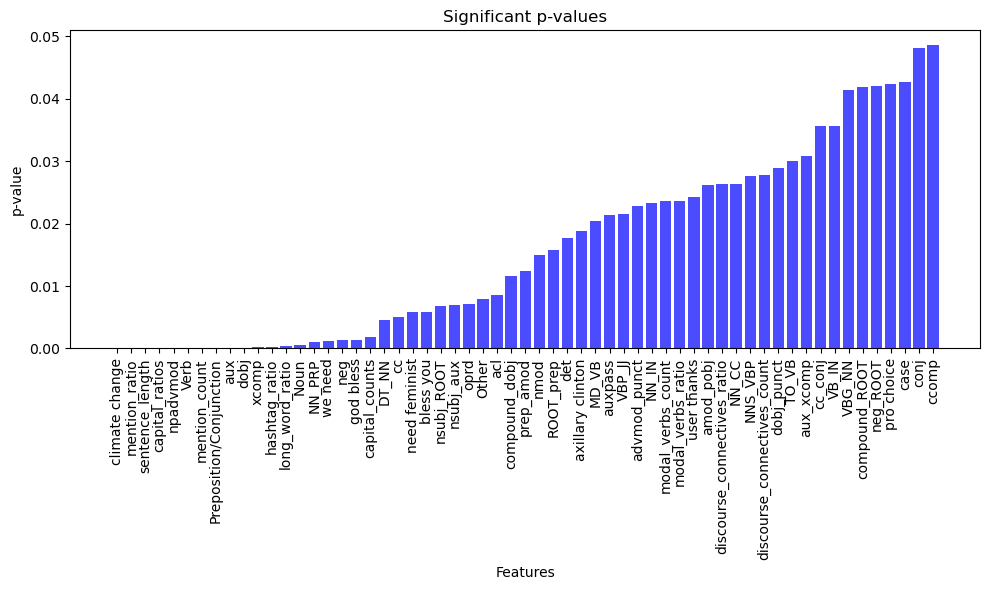

In [137]:
# Set the threshold for significance
threshold = 0.05

# Filter the significant p-values
significant_pvalues = [(pval, feature_name) for pval, feature_name in pval_feature_list if pval < threshold]

# Extract the p-values and feature names for plotting
pvalues = [pval for pval, _ in significant_pvalues]
feature_names = [feature_name for _, feature_name in significant_pvalues]

# Set the figure size
plt.figure(figsize=(10, 6))

# Plot the significant p-values
plt.bar(feature_names, pvalues, color='blue', alpha=0.7)

# Add labels and title
plt.xlabel('Features')
plt.ylabel('p-value')
plt.title('Significant p-values')

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=90)

# Show the plot
plt.tight_layout()
plt.show()

In [138]:
feature_groups_names.keys()

dict_keys(['n_grams', 'morphological', 'pragmatic', 'lexical', 'syntactic', 'structural'])

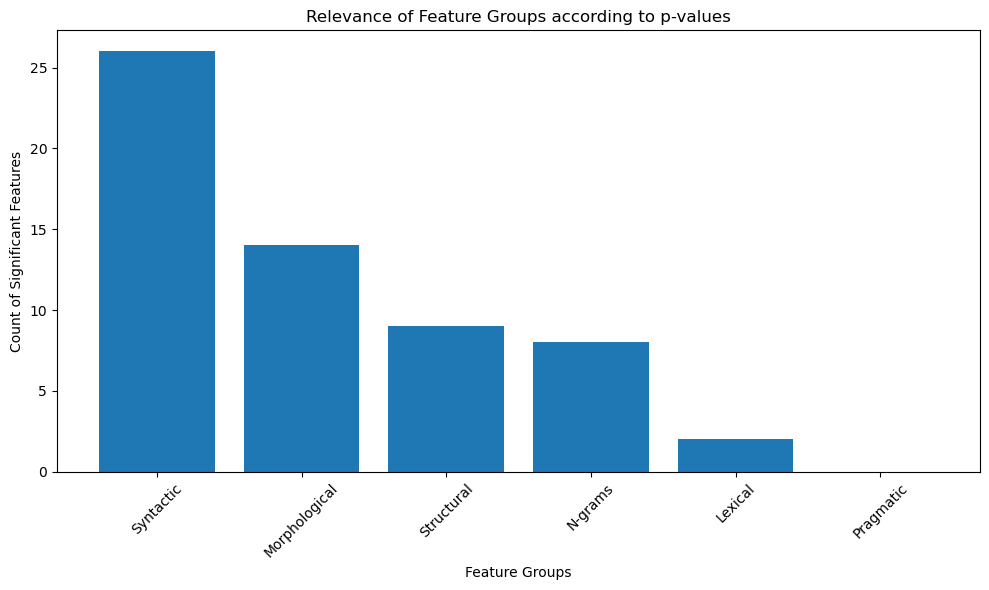

In [139]:
groups = [n_grams, morphological, pragmatic, lexical, syntactic, structural]

# Define the names of the feature groups
group_names = [
    'N-grams',
    'Morphological',
    'Pragmatic',
    'Lexical',
    'Syntactic',
    'Structural'
    # Add more feature group names in the same order as the feature_groups list
]

# Count the occurrences of significant features in each group
group_counts = [sum(feature in feature_names for feature in group) for group in groups]

# Sort the groups based on the counts in descending order
sorted_groups = sorted(zip(group_names, group_counts), key=lambda x: x[1], reverse=True)

# Extract the sorted group names and counts
group_names = [group[0] for group in sorted_groups]
group_counts = [group[1] for group in sorted_groups]

# Set the figure size
plt.figure(figsize=(10, 6))

plt.bar(group_names, group_counts)

# Add labels and title
plt.xlabel('Feature Groups')
plt.ylabel('Count of Significant Features')
plt.title('Relevance of Feature Groups according to p-values')

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

In [140]:
classes = lr_model.classes_
coefficients = lr_model.coef_

reference_class_index = list(classes).index(0)

# Print the coefficients for each class
for i, class_label in enumerate(classes):
    if i == reference_class_index:
        print(f"Coefficients for reference class {class_label} (Neutral):")
    else:
        print(f"Coefficients for class {class_label}:")
    
    # Sort the coefficients and feature names based on the absolute value of coefficients
    sorted_indices = np.argsort(np.abs(coefficients[i]))[::-1]
    sorted_features = [features_ind[j] for j in sorted_indices]
    sorted_coeffs = [coefficients[i][j] for j in sorted_indices]
    
    for feature, coefficient in zip(sorted_features, sorted_coeffs):
        print(f"{feature}: {coefficient}")

    print()

Coefficients for reference class 0 (Neutral):
climate change: -1.2519002137791186
axillary clinton: -1.0872507403401168
best your: 1.0515813475505236
god bless: 1.0420065075969802
long_word_ratio: -1.007198603188673
we re: -0.9112685430623282
tea party: 0.8696031479686329
you re: -0.7054907716856033
preconj: -0.6441995443224636
mention_ratio: 0.6215512988948918
need feminist: -0.5893859168505583
meta: 0.5566358573625719
agent: 0.5198058509372395
negative_adv_count: -0.4995426507071742
user thanks: 0.4832162267035944
know what: -0.465241005618612
you set: 0.45565215853716734
ha ha: 0.4445381089354622
you much: 0.44209962866633384
hashtag_ratio: 0.4335726600584305
nmod: 0.4247837461554237
complement_clause_ratio: 0.41555966324190424
you not: -0.39412072039547946
pro choice: -0.3940771453000145
CC_NN: 0.38937319695634176
npadvmod: 0.38878311324901643
your life: -0.3789793899183242
advmod_advmod: -0.32465109890095895
we need: -0.3144300407250726
ROOT: 0.3102844390908307
DT_NNS: 0.308122875

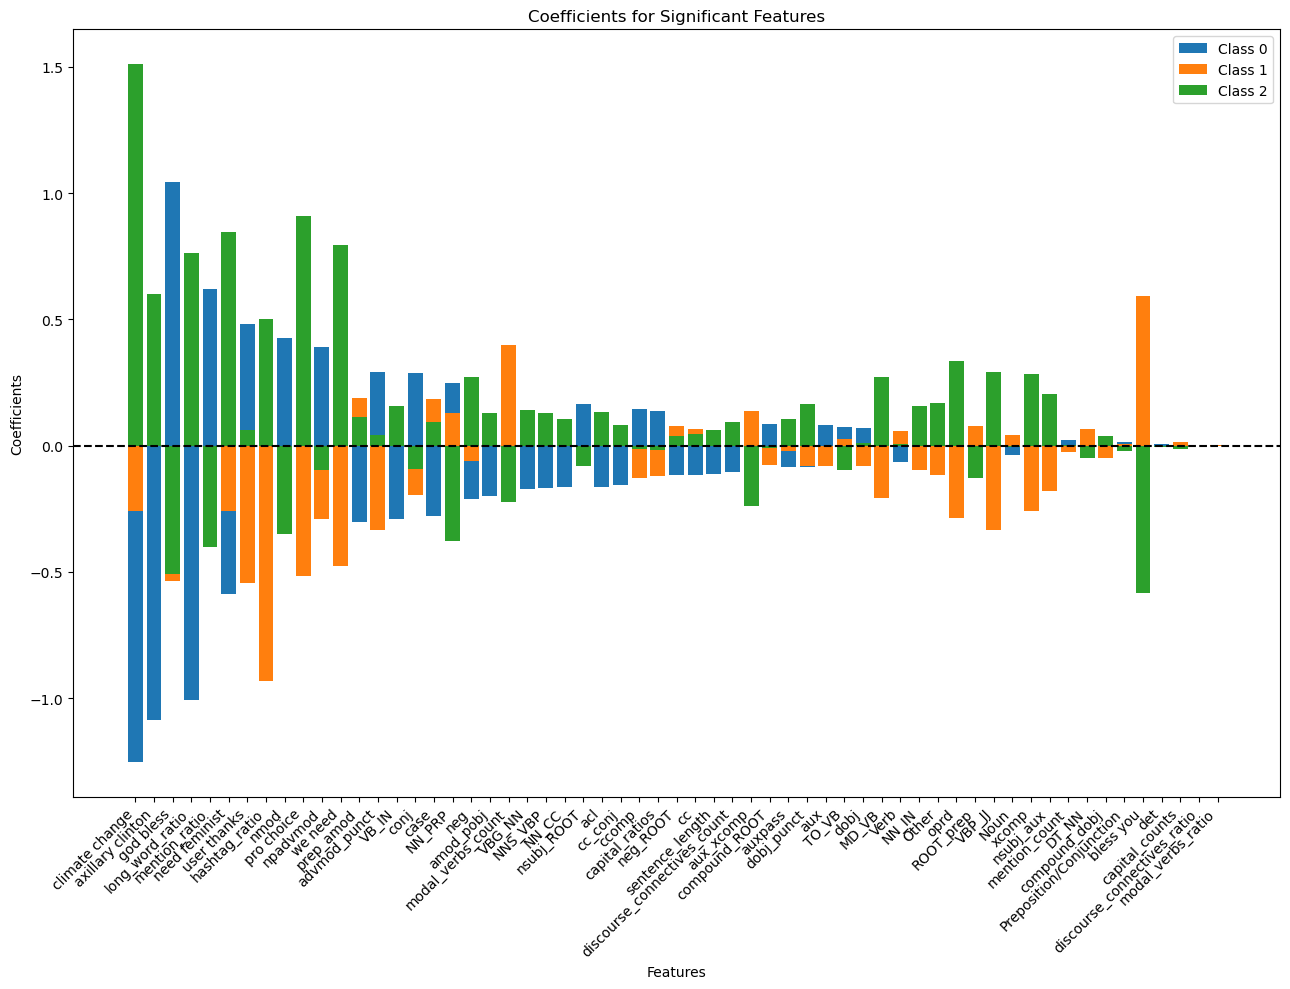

In [141]:
# Create a dictionary to store the coefficients for each class
coefficients_dict = {}

# Iterate over each class label
for i, class_label in enumerate(classes):
    # Sort the coefficients and feature names based on the absolute value of coefficients
    sorted_indices = np.argsort(np.abs(coefficients[i]))[::-1]
    sorted_features = [features_ind[j] for j in sorted_indices]
    sorted_coeffs = [coefficients[i][j] for j in sorted_indices]

    # Filter the significant features that are in the feature_names list
    significant_features_coeffs = []
    significant_features_labels = []
    for feature, coeff in zip(sorted_features, sorted_coeffs):
        if feature in feature_names and feature not in significant_features_labels:
            significant_features_labels.append(feature)
            significant_features_coeffs.append(coeff)

    # Store the significant features and coefficients in the dictionary
    coefficients_dict[class_label] = (significant_features_labels, significant_features_coeffs)

# Set the figure size
plt.figure(figsize=(13, 10))

# Plot the significant features for each class
for class_label, (features, coeffs) in coefficients_dict.items():
    plt.bar(features, coeffs, label=f"Class {class_label}")

# Add a horizontal line at y=0
plt.axhline(y=0, color='black', linestyle='--')

# Add labels and title
plt.xlabel('Features')
plt.ylabel('Coefficients')
plt.title('Coefficients for Significant Features')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()